In [2]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd

df = pd.read_parquet('/Users/abhinavrajput/Desktop/PROJECTS/NoEEG_Borealis/doa-zero-eeg-sample_filtered/80b98665-5fe0-462c-a6cd-c9b9943abc37.parquet', engine='pyarrow')

data = df

print(f"Shape of the data: {data.shape}")
print("Overview: \n")
data.head()

Shape of the data: (8846, 8)
Overview: 



SubLabel                          BIS    CO₂fe  CO₂mi  FC     PNId   PNIm   \
TimeStamp                                                                    
2022-11-01 04:35:00.658000+00:00    NaN   33.0    0.0   48.0    NaN    NaN   
2022-11-01 04:35:01.682000+00:00    NaN   33.0    0.0   47.0    NaN    NaN   
2022-11-01 04:35:02.706000+00:00    NaN   33.0    0.0   47.0    NaN    NaN   
2022-11-01 04:35:03.730000+00:00    NaN   33.0    0.0   47.0    NaN    NaN   
2022-11-01 04:35:04.754000+00:00    NaN   33.0    0.0   47.0    NaN    NaN   

SubLabel                          PNIs   SpO₂   
TimeStamp                                       
2022-11-01 04:35:00.658000+00:00    NaN  100.0  
2022-11-01 04:35:01.682000+00:00    NaN  100.0  
2022-11-01 04:35:02.706000+00:00    NaN  100.0  
2022-11-01 04:35:03.730000+00:00    NaN  100.0  
2022-11-01 04:35:04.754000+00:00    NaN  100.0

In [3]:
import numpy as np
from scipy.interpolate import interp1d

def noise_interpolate(y, scale, noise_probability = 0.25):
    x_valid = np.where(~np.isnan(y))[0]
    y_valid = y[x_valid]  # Correctly extract y_valid from y using indices
    x_missing = np.where(np.isnan(y))[0]

    # Fit a quadratic spline on the valid data points
    quadratic_spline = interp1d(x_valid, y_valid, kind='quadratic', fill_value="extrapolate")

    # Interpolate the missing (NaN) values using the spline
    y[x_missing] = quadratic_spline(x_missing)

    noise_scale = scale*(np.max(y) - np.min(y))

    noise_mask = np.random.rand(*y.shape) < noise_probability


    # Generate Gaussian noise
    noise = np.random.normal(loc=0, scale=noise_scale, size=y.shape)*noise_mask

    # Add noise to the polynomial values
    y_noisy = y + noise

    return y,y_noisy

bis = data['BIS'].values


In [8]:
import copy

def generate_arrays(data):
    _,pnim= noise_interpolate(data['PNIm'].values.flatten(),0.02 )

    bis_ = data[['BIS']].values

    i = 0
    while(not (bis_[i] >= 0)):
        i = i+1

    dataf = copy.deepcopy(data)
    dataf.fillna(method='ffill', inplace=True)


    bis = dataf[['BIS']].values
    fc = dataf[['FC']].values
    spo2 = dataf[['SpO₂']].values
    co2 = dataf[['CO₂fe']].values

    bis = bis[i:]
    fc = fc[i:]
    spo2 = spo2[i:]
    co2 = co2[i:]
    pnim = pnim[i:]

    return bis,pnim,fc,spo2,co2



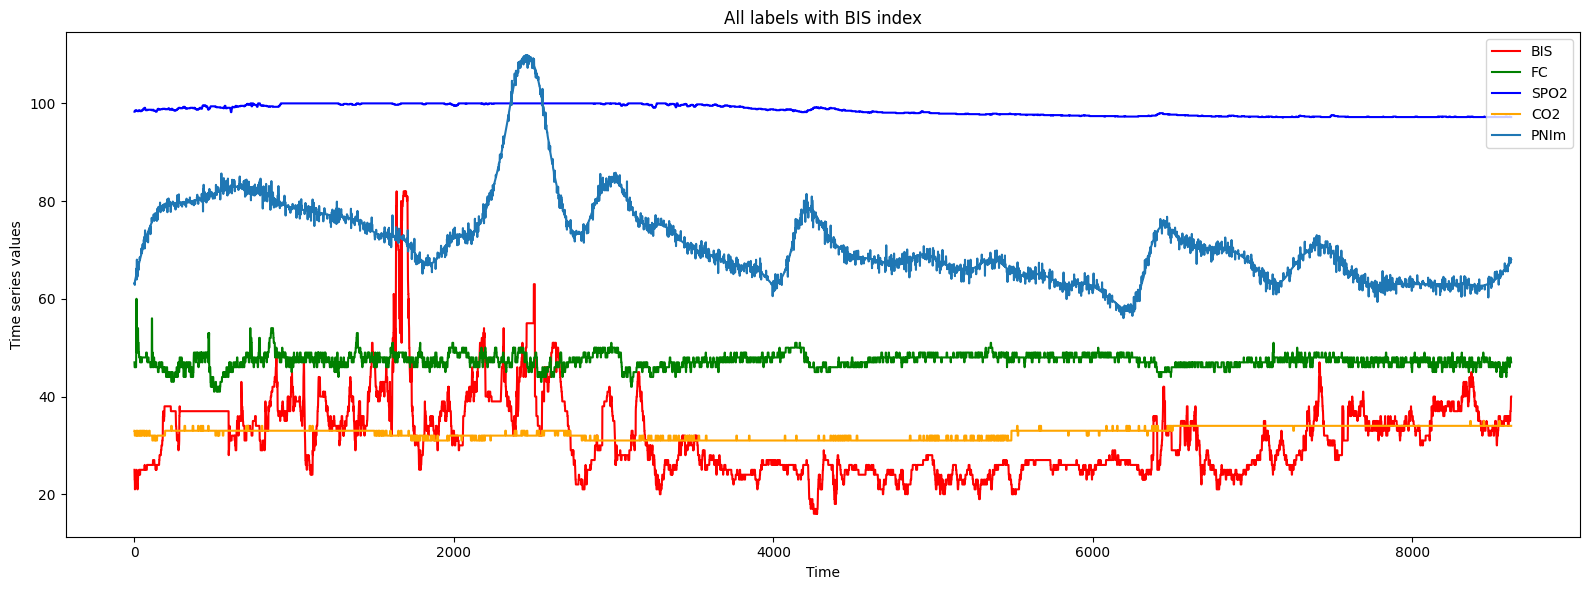

In [9]:
bis,pnim,fc,spo2,co2 = generate_arrays(data)


import numpy as np
from scipy.ndimage import gaussian_filter

import matplotlib.pyplot as plt

plt.figure(figsize=(16,6))
plt.plot(bis[:11000], label="BIS", c="r")
plt.plot(fc[:11000], label="FC", c="g")
plt.plot(spo2[:11000], label="SPO2", c="b")
plt.plot(co2[:11000], label="CO2", c="orange")
plt.plot(pnim[:11000], label="PNIm")
#plt.plot(pnim[:11000], label="PNIm")

plt.xlabel("Time")
plt.ylabel("Time series values")
plt.title("All labels with BIS index")

plt.legend(loc="upper right")
plt.tight_layout()
plt.show()

In [24]:
df = pd.DataFrame({'A': bis.flatten(), 'B': pnim.flatten(), 'C': co2.flatten(), 'D': spo2.flatten(), 'E': fc.flatten()})
df.describe()


A            B            C            D            E
count  8619.00000  8619.000000  8619.000000  8619.000000  8619.000000
mean     31.38241    71.711422    32.508759    98.580070    47.361294
std       8.14466     8.803257     1.169428     1.110026     1.459702
min      16.00000    57.574802    31.000000    97.099998    41.000000
25%      26.00000    65.514645    31.000000    97.400002    47.000000
50%      29.00000    69.767059    33.000000    98.500000    47.000000
75%      37.00000    76.515945    34.000000    99.800003    48.000000
max      82.00000   109.849884    35.000000   100.000000    60.000000

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import mean_squared_error  # Add this import

import xgboost as xgb

def calcmse(bis, pnim, co2, spo2, fc, width=42, want_to_print = False, n_estim=4):
    df = pd.DataFrame({
        'A': bis.flatten(), 
        'B': pnim.flatten(), 
        'C': co2.flatten(), 
        'D': spo2.flatten(), 
        'E': fc.flatten()
    })

    window_size = width
    # Create lagged features for the desired window size
    for lag in range(1, window_size + 1):
        df[f'B_lag{lag}'] = df['B'].shift(lag)
        df[f'C_lag{lag}'] = df['C'].shift(lag)
        df[f'D_lag{lag}'] = df['D'].shift(lag)
        df[f'E_lag{lag}'] = df['E'].shift(lag)

    # Drop rows with NaN values resulting from the shift operation AFTER creating all lags
    df = df.dropna()

    # Define features (including all lags for B, C, D, and E) and target (A)
    features = [f'{var}_lag{lag}' for var in ['B', 'C', 'D', 'E',] for lag in range(1, window_size + 1)]
    X = df[features]
    y = df['A']

    n = 0.9
    # Calculate the split index
    split_index = int(n * len(X))

    # Split the data into training and testing sets
    X_train, X_ = X[:split_index], X[split_index:]
    y_train, y_ = y[:split_index], y[split_index:]

    n = 0.5

    split_index = int(n * len(X_))

    X_Val, X_test = X_[:split_index], X_[split_index:]
    y_Val, y_test = y_[:split_index], y_[split_index:]

    # Initialize the XGBoost regressor
    model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=n_estim)

    # Train the model
    model.fit(X_train, y_train)

    # Predict the test set
    y_pred = model.predict(X_test)
    y_total = model.predict(X)

    # Calculate the mean squared error
    mse = mean_squared_error(y_test, y_pred)

    y_pred_val = model.predict(X_Val)
    mse_Val = mean_squared_error(y_Val, y_pred_val)


    if(want_to_print):
        print("TEST")
        plt.figure(figsize=(16,6))
        plt.plot(y_test.values, label="BIS_actual", c="r")
        plt.plot(y_pred, label="BIS_pred", c="b")
        plt.xlabel("Time")
        plt.ylabel("Time series values")
        plt.title("All labels with BIS index")
        plt.legend(loc="upper right")
        plt.tight_layout()
        plt.show()
        print("TOTAL")
        plt.figure(figsize=(16,6))
        plt.plot(y.values, label="BIS_actual", c="r")
        plt.plot(y_total, label="BIS_pred", c="b")
        plt.xlabel("Time")
        plt.ylabel("Time series values")
        plt.title("All labels with BIS index")
        plt.legend(loc="upper right")
        plt.tight_layout()
        plt.show()
        
    return mse, mse_Val


In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import mean_squared_error  # Add this import

import xgboost as xgb

def calcmse_aa(bis, pnim, width=42, want_to_print = False, n_estim=4):
    df = pd.DataFrame({
        'A': bis.flatten(), 
        'B': pnim.flatten(), 
    })

    window_size = width
    # Create lagged features for the desired window size
    for lag in range(1, window_size + 1):
        df[f'B_lag{lag}'] = df['B'].shift(lag)

    # Drop rows with NaN values resulting from the shift operation AFTER creating all lags
    df = df.dropna()

    # Define features (including all lags for B, C, D, and E) and target (A)
    features = [f'{var}_lag{lag}' for var in ['B'] for lag in range(1, window_size + 1)]
    X = df[features]
    y = df['A']

    n = 0.9
    # Calculate the split index
    split_index = int(n * len(X))

    # Split the data into training and testing sets
    X_train, X_ = X[:split_index], X[split_index:]
    y_train, y_ = y[:split_index], y[split_index:]

    n = 0.5

    split_index = int(n * len(X_))

    X_Val, X_test = X_[:split_index], X_[split_index:]
    y_Val, y_test = y_[:split_index], y_[split_index:]

    # Initialize the XGBoost regressor
    model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=n_estim)

    # Train the model
    model.fit(X_train, y_train)

    # Predict the test set
    y_pred = model.predict(X_test)
    y_total = model.predict(X)

    # Calculate the mean squared error
    mse = mean_squared_error(y_test, y_pred)

    y_pred_val = model.predict(X_Val)
    mse_Val = mean_squared_error(y_Val, y_pred_val)


    if(want_to_print):
        print("TEST")
        plt.figure(figsize=(16,6))
        plt.plot(y_test.values, label="BIS_actual", c="r")
        plt.plot(y_pred, label="BIS_pred", c="b")
        plt.xlabel("Time")
        plt.ylabel("Time series values")
        plt.title("All labels with BIS index")
        plt.legend(loc="upper right")
        plt.tight_layout()
        plt.show()
        print("TOTAL")
        plt.figure(figsize=(16,6))
        plt.plot(y.values, label="BIS_actual", c="r")
        plt.plot(y_total, label="BIS_pred", c="b")
        plt.xlabel("Time")
        plt.ylabel("Time series values")
        plt.title("All labels with BIS index")
        plt.legend(loc="upper right")
        plt.tight_layout()
        plt.show()
        
    return mse, mse_Val


TEST


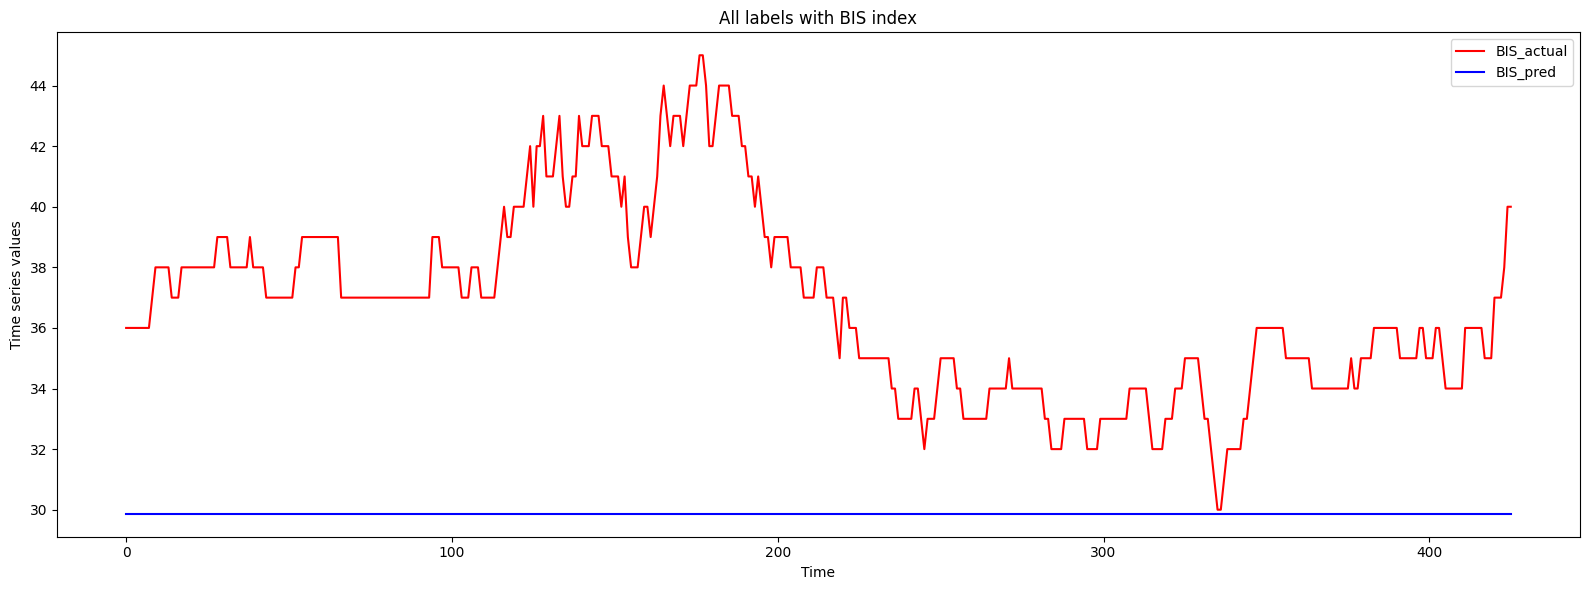

TOTAL


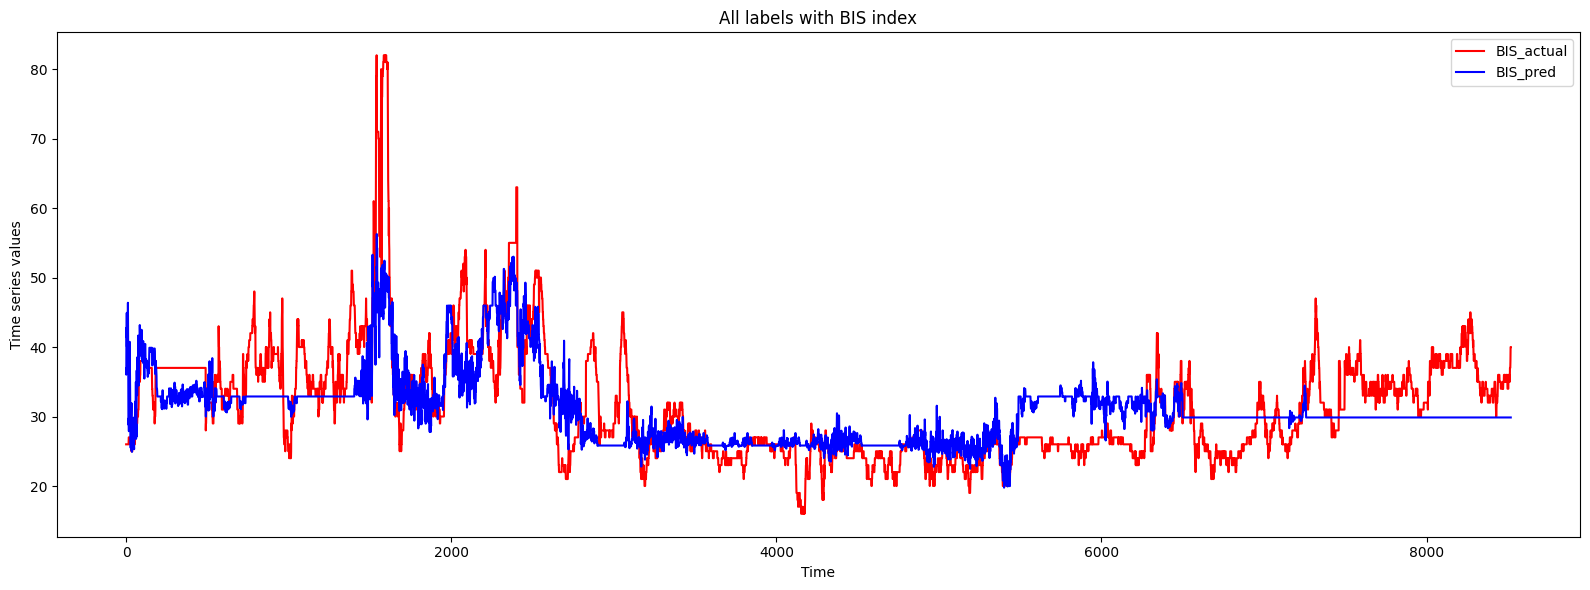

In [30]:
mse, _ = calcmse_aa(bis, co2, 100, True,10)

In [8]:
# import torch
# import torch.nn as nn
# import numpy as np

# # Define the LSTM model class
# class LSTMPredictor(nn.Module):
#     def __init__(self, input_size, hidden_layer_size, output_size):
#         super(LSTMPredictor, self).__init__()
#         self.hidden_layer_size = hidden_layer_size
#         self.lstm = nn.LSTM(input_size, hidden_layer_size, batch_first=True)
#         self.linear = nn.Linear(hidden_layer_size, output_size)

#     def forward(self, input_seq):
#         lstm_out, _ = self.lstm(input_seq)
#         predictions = self.linear(lstm_out[:, -1, :])
#         return predictions

# # Function to create sequences of data for training
# def create_sequences(B, C, D, E, A, seq_length):
#     sequences = []
#     targets = []
#     for i in range(len(A) - seq_length):
#         seq = np.vstack((B[i:i+seq_length], C[i:i+seq_length], D[i:i+seq_length], E[i:i+seq_length])).T
#         target = A[i+seq_length]
#         sequences.append(seq)
#         targets.append(target)
#     return torch.FloatTensor(sequences), torch.FloatTensor(targets)

# # Hyperparameters
# input_size = 4
# hidden_layer_size = 100
# output_size = 1
# seq_length = 60
# epochs = 100
# batch_size = 16

# # Instantiate the model, change loss function to MAE, and define optimizer
# model = LSTMPredictor(input_size, hidden_layer_size, output_size)
# loss_function = nn.L1Loss()  # Use Mean Absolute Error Loss
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# # Example data (replace with real data)
# np.random.seed(0)
# B = fc.flatten()
# C = spo2.flatten()
# D = pnim.flatten()
# E = co2.flatten()
# A = bis.flatten()

# sequences, targets = create_sequences(B, C, D, E, A, seq_length)

# test_size = int(len(sequences) * 0.2)
# train_sequences = sequences[:-test_size]
# test_sequences = sequences[-test_size:]
# train_targets = targets[:-test_size]
# test_targets = targets[-test_size:]

# # Training and testing loop with MAE loss
# for epoch in range(epochs):
#     model.train()
#     train_loss = 0.0
#     for i in range(0, len(train_sequences), batch_size):
#         optimizer.zero_grad()
#         batch_x, batch_y = train_sequences[i:i+batch_size], train_targets[i:i+batch_size]
#         y_pred = model(batch_x)
#         loss = loss_function(y_pred.squeeze(), batch_y)
#         loss.backward()
#         optimizer.step()
#         train_loss += loss.item() * batch_x.size(0)
#     train_loss /= len(train_sequences)

#     # Test loop
#     model.eval()
#     test_loss = 0.0
#     with torch.no_grad():
#         for i in range(0, len(test_sequences), batch_size):
#             batch_x, batch_y = test_sequences[i:i+batch_size], test_targets[i:i+batch_size]
#             y_pred = model(batch_x)
#             loss = loss_function(y_pred.squeeze(), batch_y)
#             print(batch_y.shape)
#             test_loss += loss.item() * batch_x.size(0)
#     test_loss /= len(test_sequences)

#     print(f'Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')

In [9]:
# #fine tune 

# i = 1
# mse = []
# m = 1e10
# ind = 10000
# while(i<51):
#     _,k = calcmse(bis, pnim,co2,spo2,fc,i,False,100)
#     if(k < m):
#         m = k
#         ind = i
#     mse.append(k)
#     print(i)
#     i = i+1

# print("min arg width = ", ind)

# plt.figure(figsize=(16,6))

# plt.plot(mse, label="MSE", c="r")

# plt.xlabel("width")
# plt.ylabel("MSE")
# plt.title("All labels with BIS index")

# plt.legend(loc="upper right")
# plt.tight_layout()
# plt.show()

In [10]:
# calcmse(bis, pnim,co2,spo2,fc,ind,True,100)


In [31]:
import pandas as pd
import glob
import os
import random

# Corrected the path and pattern to match .parquet files
path = r'/Users/abhinavrajput/Desktop/PROJECTS/NoEEG_Borealis/doa-zero-eeg-sample_filtered'
all_files = glob.glob(os.path.join(path, "*.parquet"))

li = []

for filename in all_files:
    # Removed the index_col and header parameters
    df = pd.read_parquet(filename)
    li.append(df)

random.shuffle(li)

#frame = pd.concat(li, axis=0, ignore_index=True)

In [32]:


######## K FOLD TRAINING #######

def kfold(lst, k):
    n = len(lst)
    slice_size = n // k  
    remainder = n % k  
    slices = []
    start = 0
    for i in range(k):
        end = start + slice_size + (1 if remainder > 0 else 0)
        remainder -= 1
        slices.append(lst[start:end])
        start = end
    return slices


In [33]:
#data = kfold(li, 5)


data = []
data.append(li[0:20])
data.append(li[20:40])
data.append(li[40:60])
data.append(li[60:80])
data.append(li[80:100])

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import mean_squared_error  # Add this import
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
import xgboost as xgb

def calcmse2(bis, pnim, co2, spo2, fc, bist, pnimt, co2t, spo2t, fct, width=42, want_to_print = False, n_estim=4):
    df = pd.DataFrame({
        'A': bis.flatten(), 
        'B': pnim.flatten(), 
        'C': co2.flatten(), 
        'D': spo2.flatten(), 
        'E': fc.flatten()
    })

    dft = pd.DataFrame({
        'A': bist.flatten(), 
        'B': pnimt.flatten(), 
        'C': co2t.flatten(), 
        'D': spo2t.flatten(), 
        'E': fct.flatten()
    })

    window_size = width

    for lag in range(1, window_size + 1):
        df[f'B_lag{lag}'] = df['B'].shift(lag)
        df[f'C_lag{lag}'] = df['C'].shift(lag)
        df[f'D_lag{lag}'] = df['D'].shift(lag)
        df[f'E_lag{lag}'] = df['E'].shift(lag)


    for lag in range(1, window_size + 1):
        dft[f'B_lag{lag}'] = dft['B'].shift(lag)
        dft[f'C_lag{lag}'] = dft['C'].shift(lag)
        dft[f'D_lag{lag}'] = dft['D'].shift(lag)
        dft[f'E_lag{lag}'] = dft['E'].shift(lag)

    df = df.dropna()
    dft = dft.dropna()

    features = [f'{var}_lag{lag}' for var in ['B', 'C', 'D', 'E',] for lag in range(1, window_size + 1)]
    X = df[features]
    y = df['A']

    Xt = dft[features]
    yt = dft['A']

    n = 0.9
    # Calculate the split index
    split_index = int(n * len(X))

    X_train = X
    y_train = y

    # Split the data into training and testing sets
    # X_train, X_ = X[:split_index], X[split_index:]
    # y_train, y_ = y[:split_index], y[split_index:]


    model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=n_estim)

    model.fit(X_train, y_train)

    y_pred = model.predict(Xt)
    y_total = model.predict(X)

    # y_pred2 = model.predict(X_)

    # mse = mean_squared_error(yt, y_pred)
    mae = mean_absolute_error(yt,y_pred)

    if(want_to_print):
        # print("Temp")
        # plt.figure(figsize=(16,6))
        # #VISUALIZING A RANDOM PORTION OF TEST SURGERY
        # plt.plot(y_.values[:2000], label="BIS_actual", c="r")
        # plt.plot(y_pred2[:2000], label="BIS_pred", c="b")
        # plt.xlabel("Time")
        # plt.ylabel("Time series values")
        # plt.title("All labels with BIS index")
        # plt.legend(loc="upper right")
        # plt.tight_layout()
        # plt.show()

        print("TEST")
        plt.figure(figsize=(16,6))
        #VISUALIZING A RANDOM PORTION OF TEST SURGERY
        plt.plot(yt.values[3000:8000], label="BIS_actual", c="r")
        plt.plot(y_pred[3000:8000], label="BIS_pred", c="b")
        plt.xlabel("Time")
        plt.ylabel("Time series values")
        plt.title("All labels with BIS index")
        plt.legend(loc="upper right")
        plt.tight_layout()
        plt.show()
        print("TOTAL")
        plt.figure(figsize=(16,6))
        plt.plot(y.values, label="BIS_actual", c="r")
        plt.plot(y_total, label="BIS_pred", c="b")
        plt.xlabel("Time")
        plt.ylabel("Time series values")
        plt.title("All labels with BIS index")
        plt.legend(loc="upper right")
        plt.tight_layout()
        plt.show()

    print("R2 score : ", r2_score(yt, y_pred))
    return mae


In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import mean_squared_error  # Add this import
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
import xgboost as xgb

def calcmse3(bis, pnim, bist, pnimt, width=42, want_to_print = False, n_estim=4):
    df = pd.DataFrame({
        'A': bis.flatten(), 
        'B': pnim.flatten(), 
    })

    dft = pd.DataFrame({
        'A': bist.flatten(), 
        'B': pnimt.flatten(), 
    })

    window_size = width

    for lag in range(1, window_size + 1):
        df[f'B_lag{lag}'] = df['B'].shift(lag)

    for lag in range(1, window_size + 1):
        dft[f'B_lag{lag}'] = dft['B'].shift(lag)


    df = df.dropna()
    dft = dft.dropna()

    features = [f'{var}_lag{lag}' for var in ['B'] for lag in range(1, window_size + 1)]
    X = df[features]
    y = df['A']

    Xt = dft[features]
    yt = dft['A']

    n = 0.9
    # Calculate the split index
    split_index = int(n * len(X))

    X_train = X
    y_train = y

    # Split the data into training and testing sets
    # X_train, X_ = X[:split_index], X[split_index:]
    # y_train, y_ = y[:split_index], y[split_index:]


    model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=n_estim)

    model.fit(X_train, y_train)

    y_pred = model.predict(Xt)
    y_total = model.predict(X)

    # y_pred2 = model.predict(X_)

    # mse = mean_squared_error(yt, y_pred)
    mae = mean_absolute_error(yt,y_pred)

    if(want_to_print):
        # print("Temp")
        # plt.figure(figsize=(16,6))
        # #VISUALIZING A RANDOM PORTION OF TEST SURGERY
        # plt.plot(y_.values[:2000], label="BIS_actual", c="r")
        # plt.plot(y_pred2[:2000], label="BIS_pred", c="b")
        # plt.xlabel("Time")
        # plt.ylabel("Time series values")
        # plt.title("All labels with BIS index")
        # plt.legend(loc="upper right")
        # plt.tight_layout()
        # plt.show()

        print("TEST")
        plt.figure(figsize=(16,6))
        #VISUALIZING A RANDOM PORTION OF TEST SURGERY
        plt.plot(yt.values[3000:8000], label="BIS_actual", c="r")
        plt.plot(y_pred[3000:8000], label="BIS_pred", c="b")
        plt.xlabel("Time")
        plt.ylabel("Time series values")
        plt.title("All labels with BIS index")
        plt.legend(loc="upper right")
        plt.tight_layout()
        plt.show()
        print("TOTAL")
        plt.figure(figsize=(16,6))
        plt.plot(y.values, label="BIS_actual", c="r")
        plt.plot(y_total, label="BIS_pred", c="b")
        plt.xlabel("Time")
        plt.ylabel("Time series values")
        plt.title("All labels with BIS index")
        plt.legend(loc="upper right")
        plt.tight_layout()
        plt.show()

    print("R2 score : ", r2_score(yt, y_pred))
    return mae


TEST


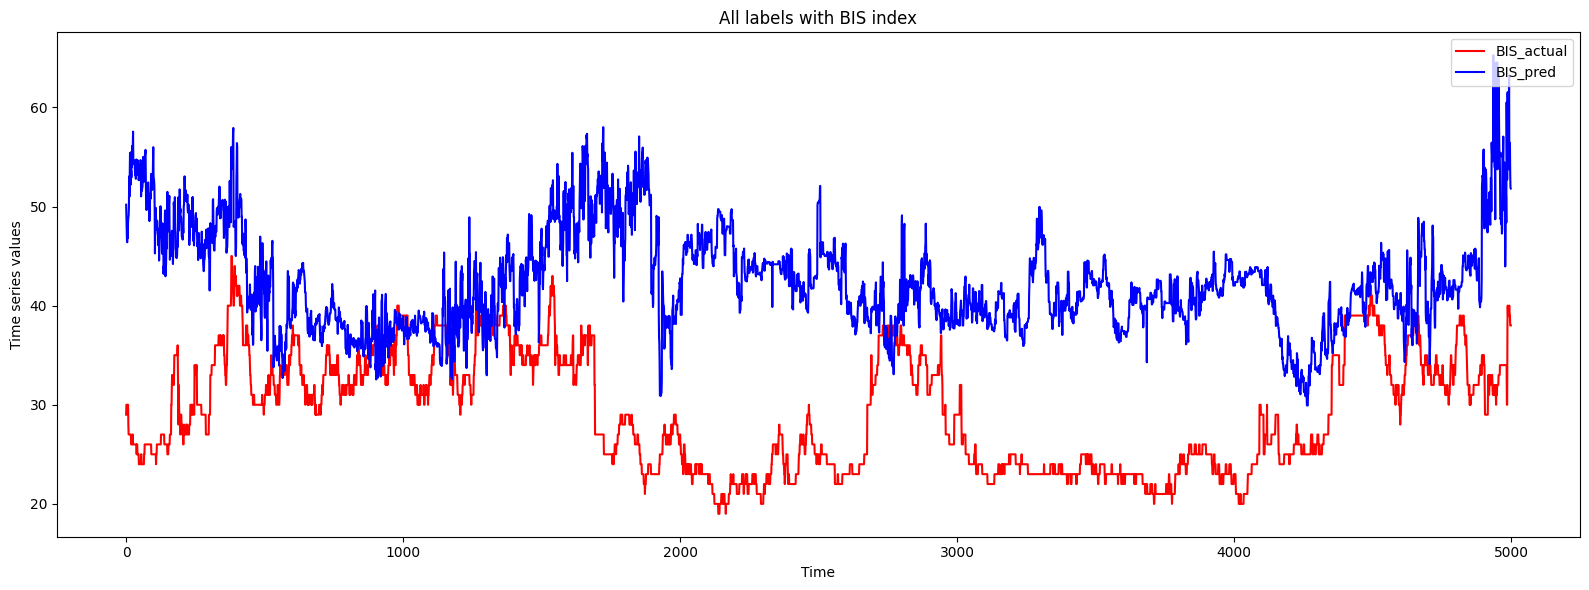

TOTAL


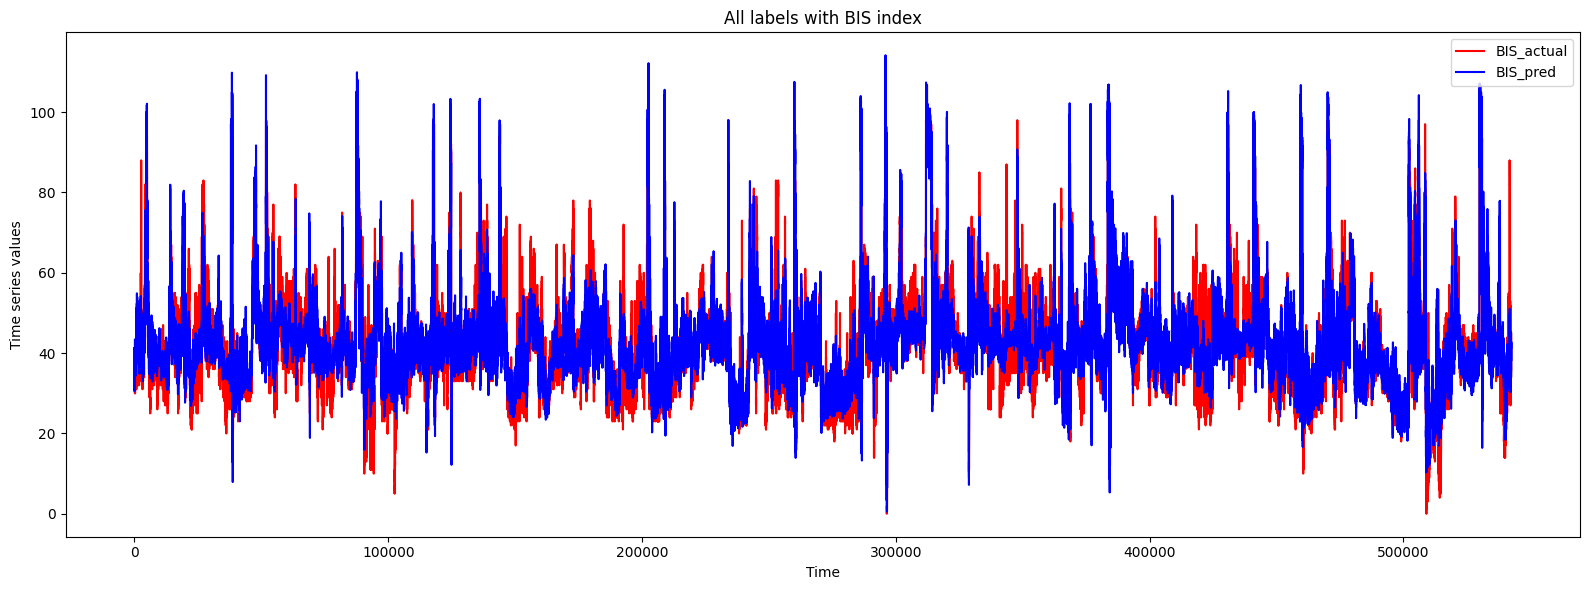

R2 score :  -0.09684250286724971
MAE for fold  {1}  =  12.220985
__________________
TEST


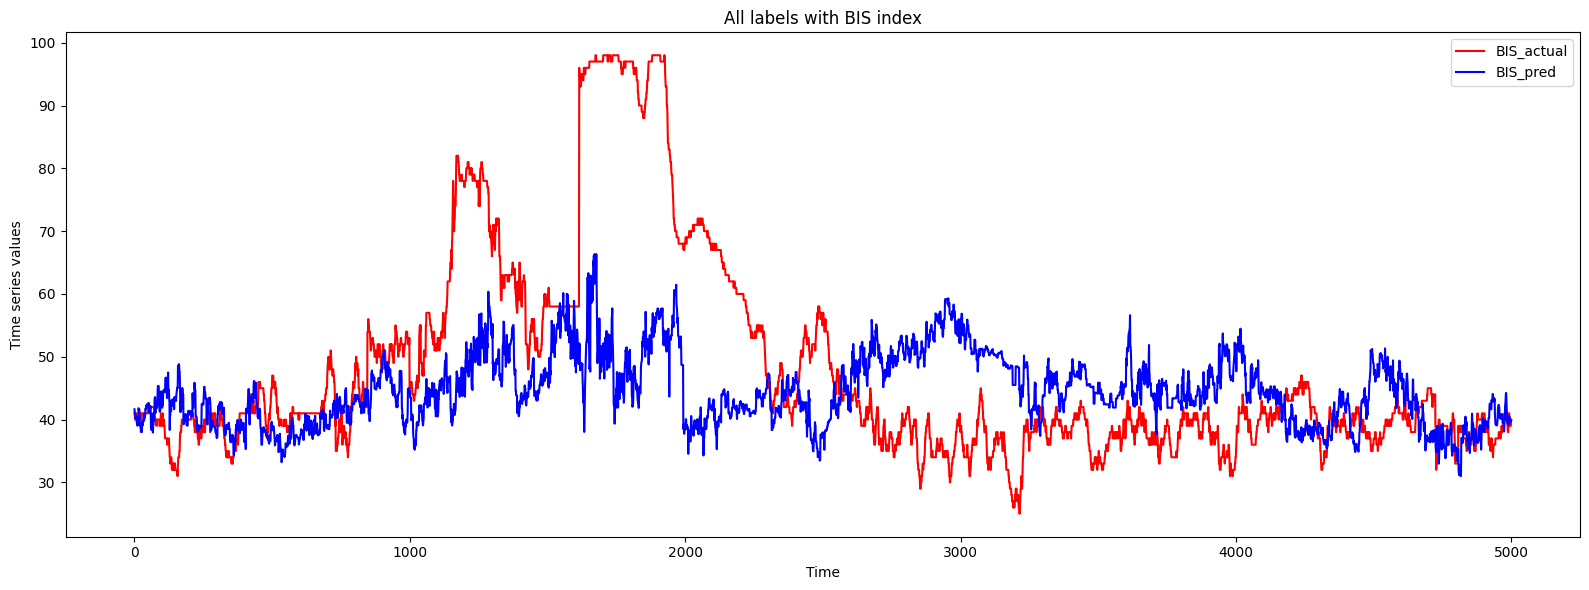

TOTAL


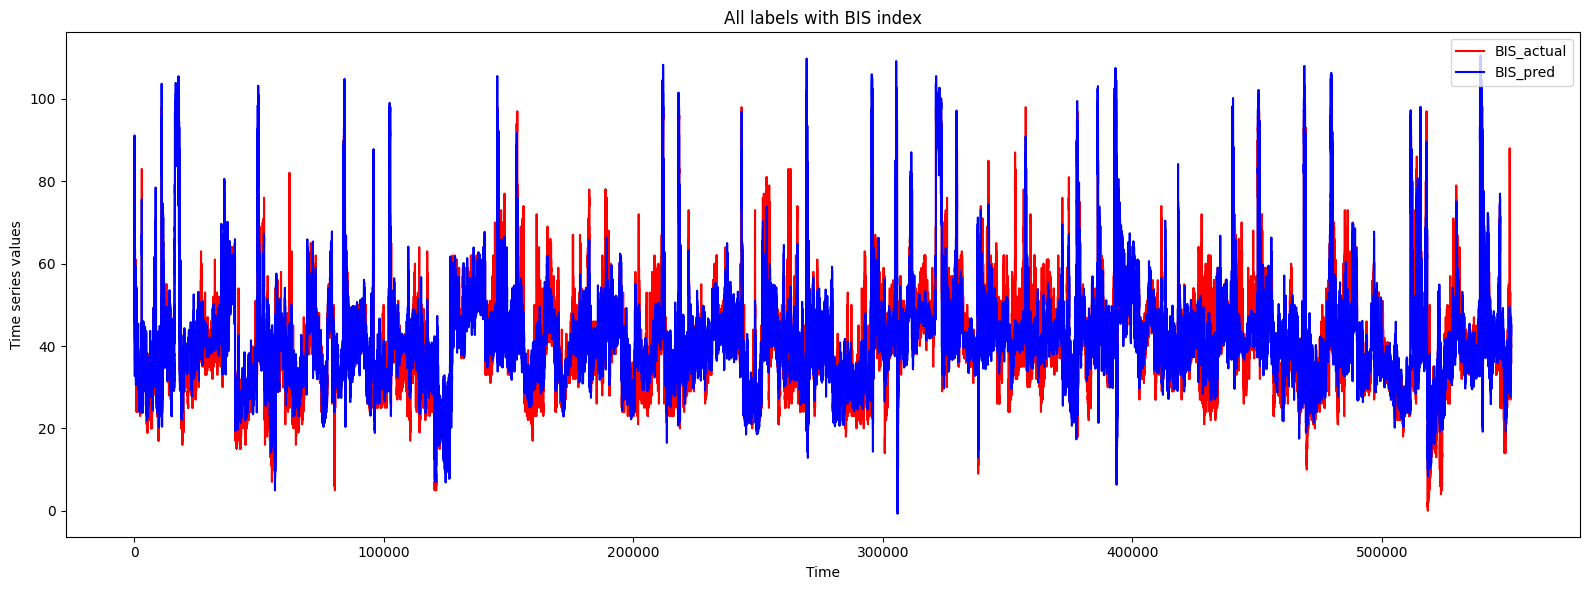

R2 score :  0.07890414913531252
MAE for fold  {2}  =  9.324267
__________________
TEST


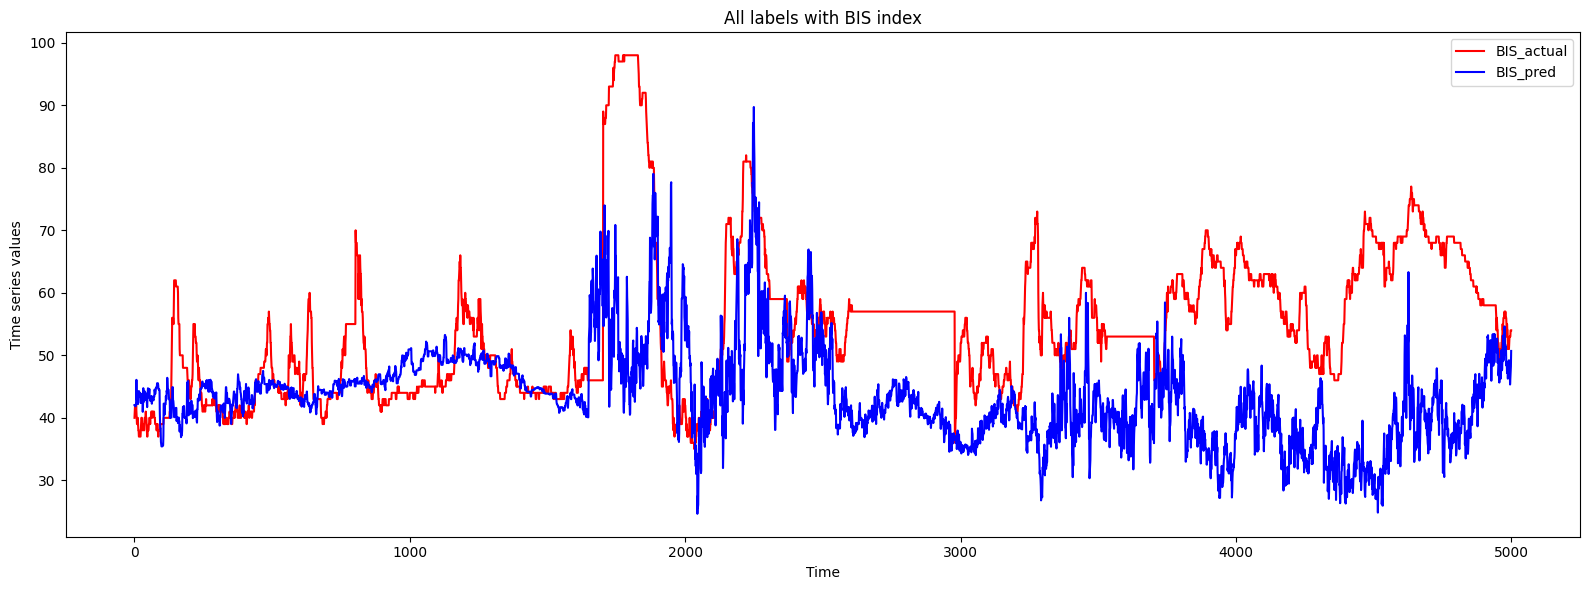

TOTAL


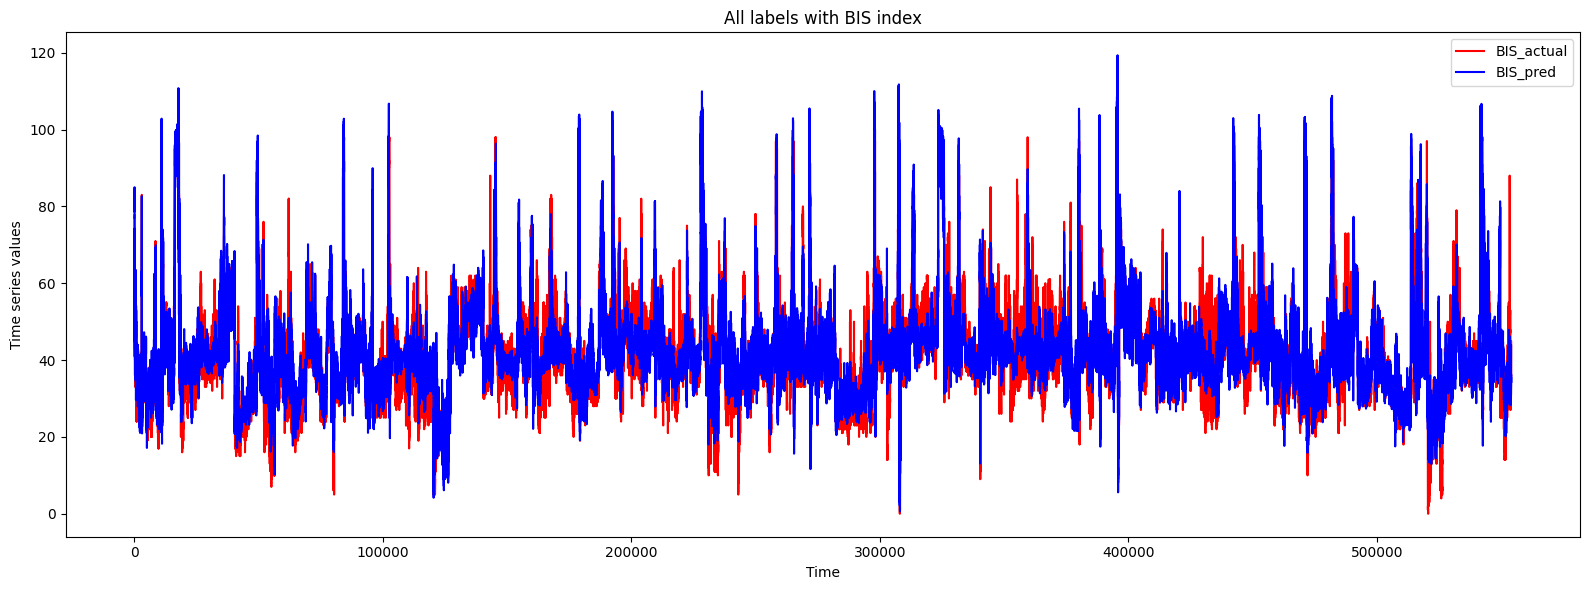

R2 score :  0.046267507017846876
MAE for fold  {3}  =  8.774193
__________________
TEST


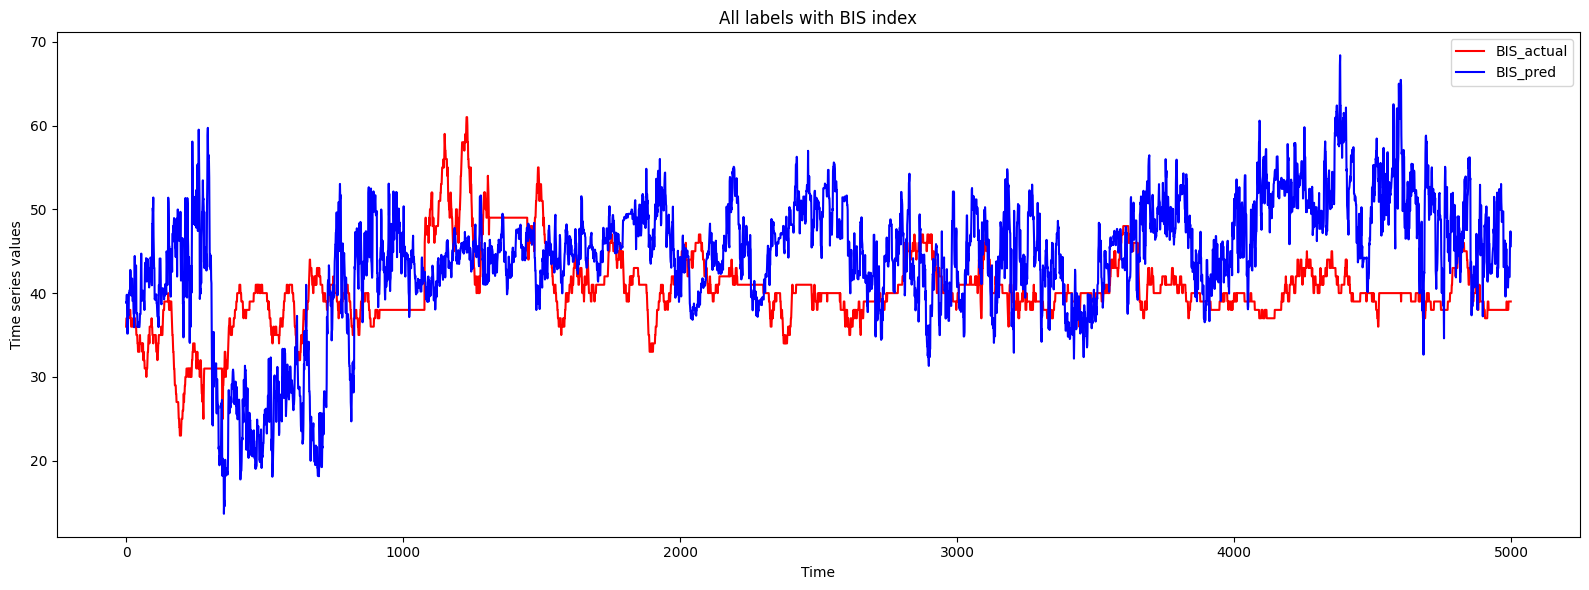

TOTAL


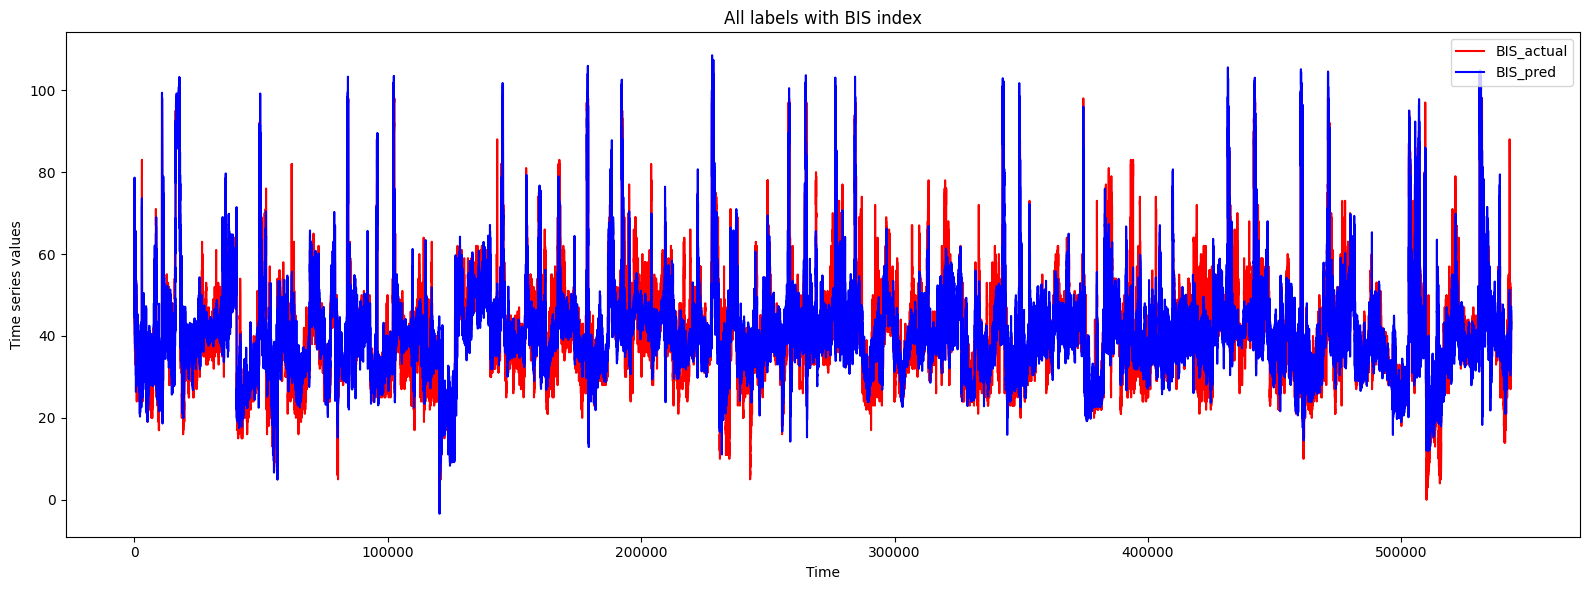

R2 score :  -0.048406914481595065
MAE for fold  {4}  =  10.960686
__________________
TEST


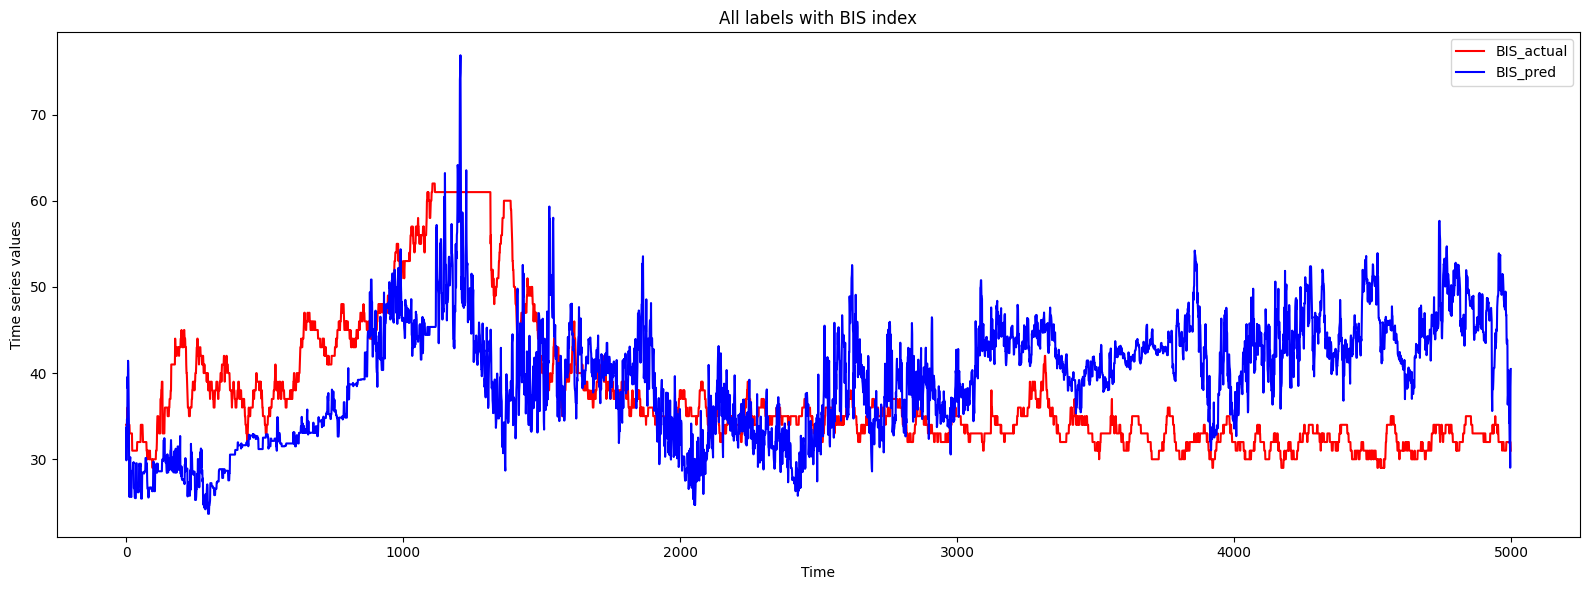

TOTAL


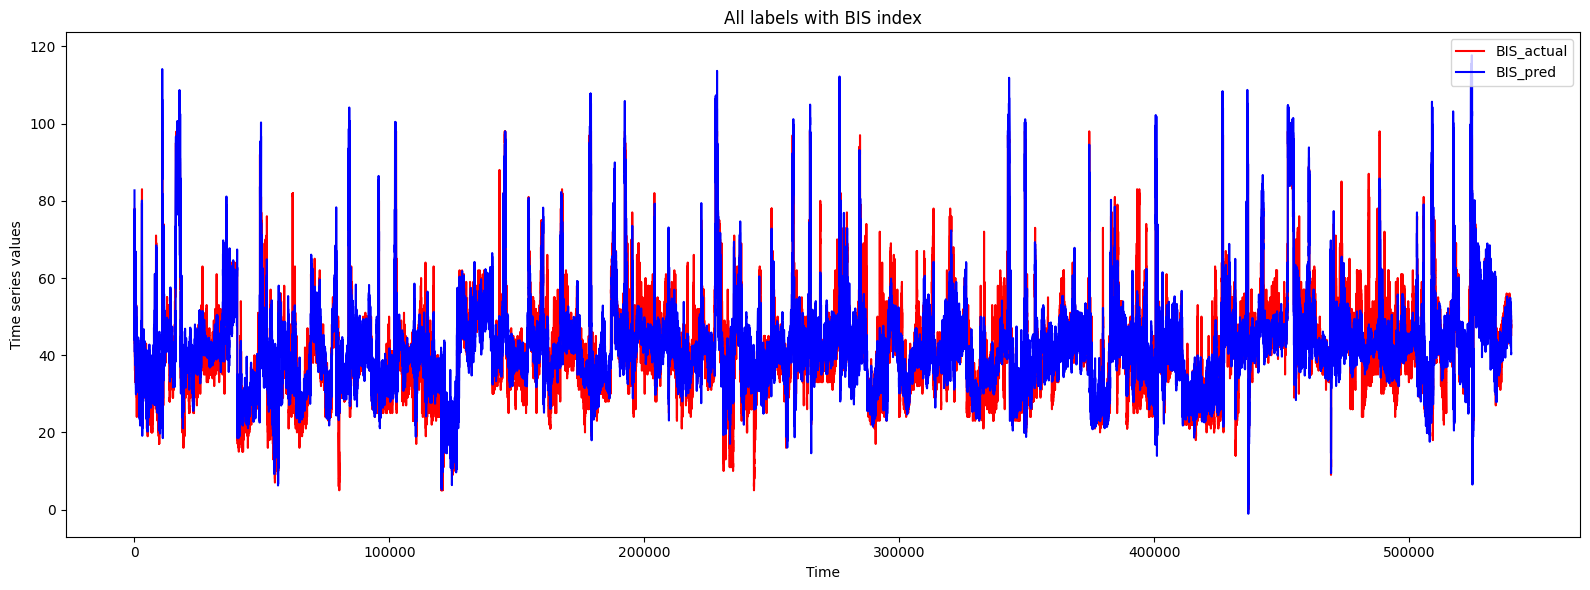

R2 score :  0.009402516140769146
MAE for fold  {5}  =  11.196483
__________________
AVG MAE  10.495322799682617


In [35]:
mae = 0
k = 5

i = 0
while i < k:
    testli = data[i]
    j = 0
    trainli = []
    while j < k:
        if (j == i):
            pass
        else:
            trainli = trainli + data[j]
        j = j+1
    
    testdf = pd.concat(testli, axis=0, ignore_index=True)
    traindf = pd.concat(trainli, axis=0, ignore_index=True)

    bis_t,pnim_t,fc_t,spo2_t,co2_t = generate_arrays(testdf)
    bis,pnim,fc,spo2,co2 = generate_arrays(traindf)

    mae_ = calcmse2(bis, pnim, co2, spo2, fc, bis_t, pnim_t, co2_t, spo2_t, fc_t, width=100, want_to_print = True, n_estim=100)
    mae = mae + mae_
    
    print("MAE for fold ", {i+1}, " = ",  mae_)
    print("__________________")

    i = i+1

print("AVG MAE ", mae/k)



TEST


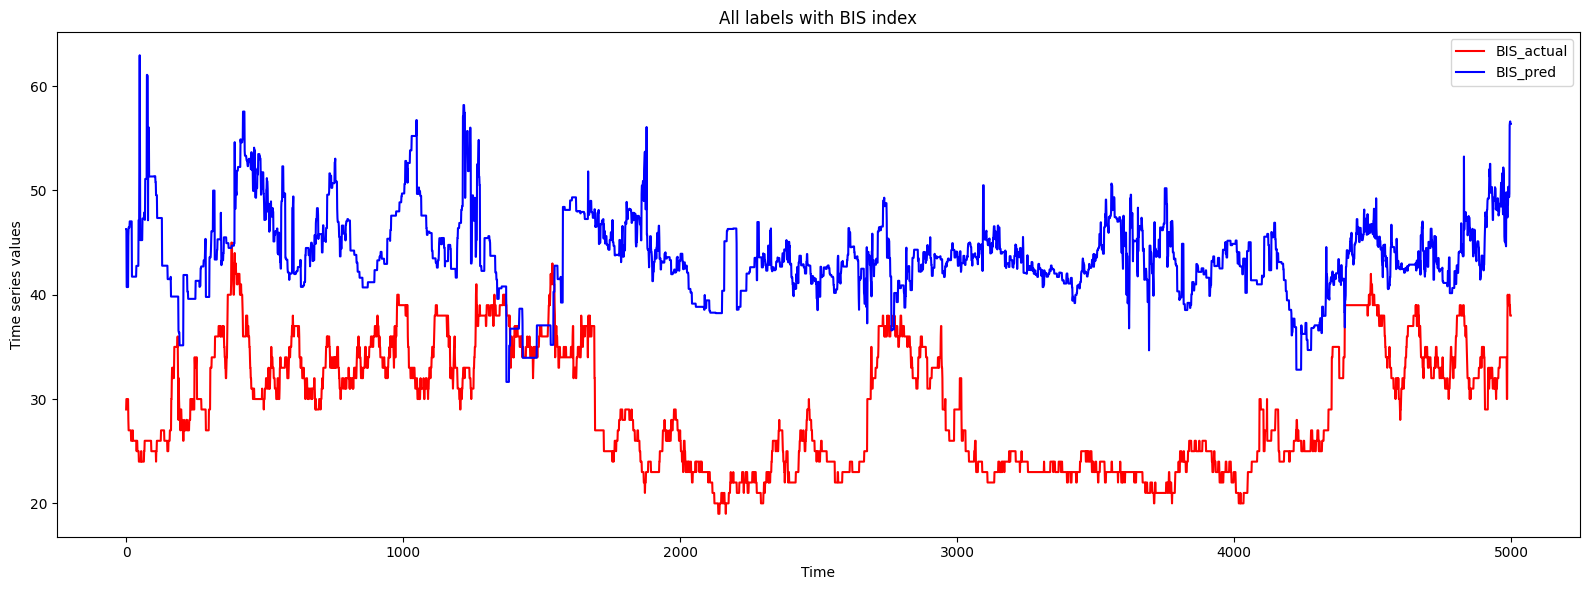

TOTAL


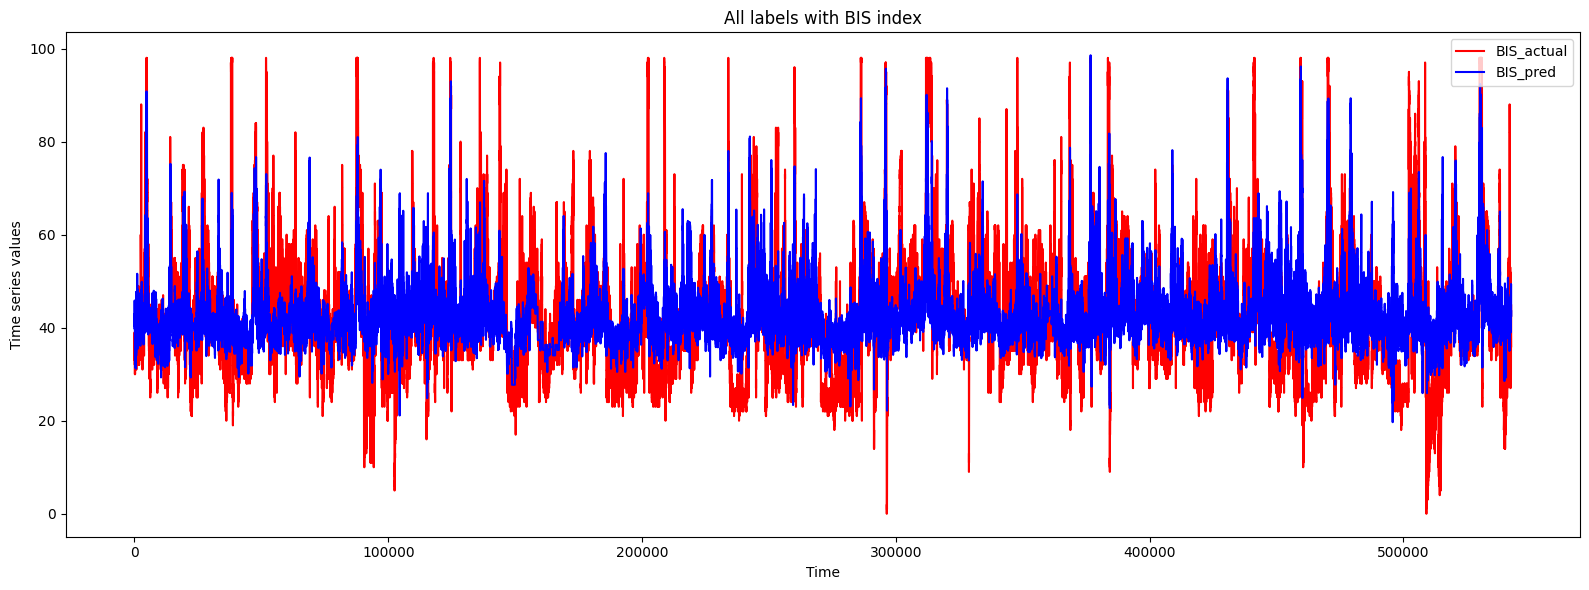

R2 score :  -0.11285690872203924
MAE for fold  {1}  =  12.001508
__________________
TEST


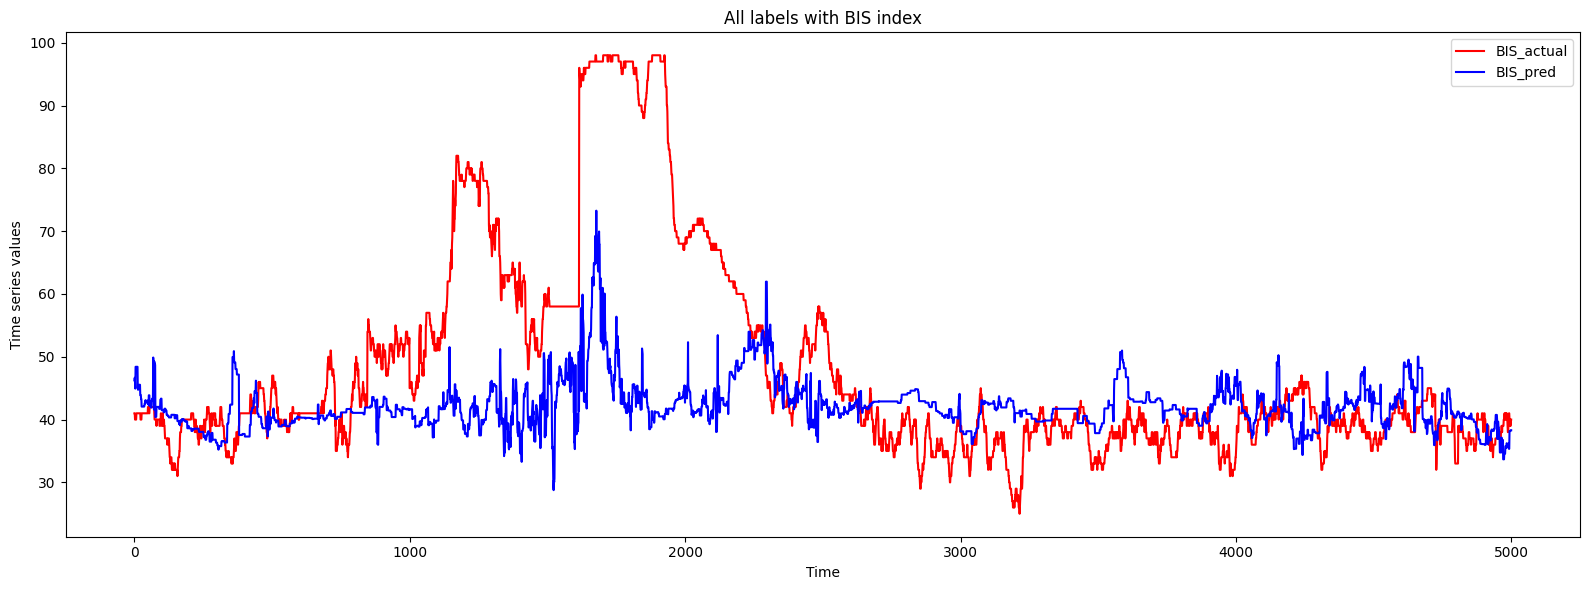

TOTAL


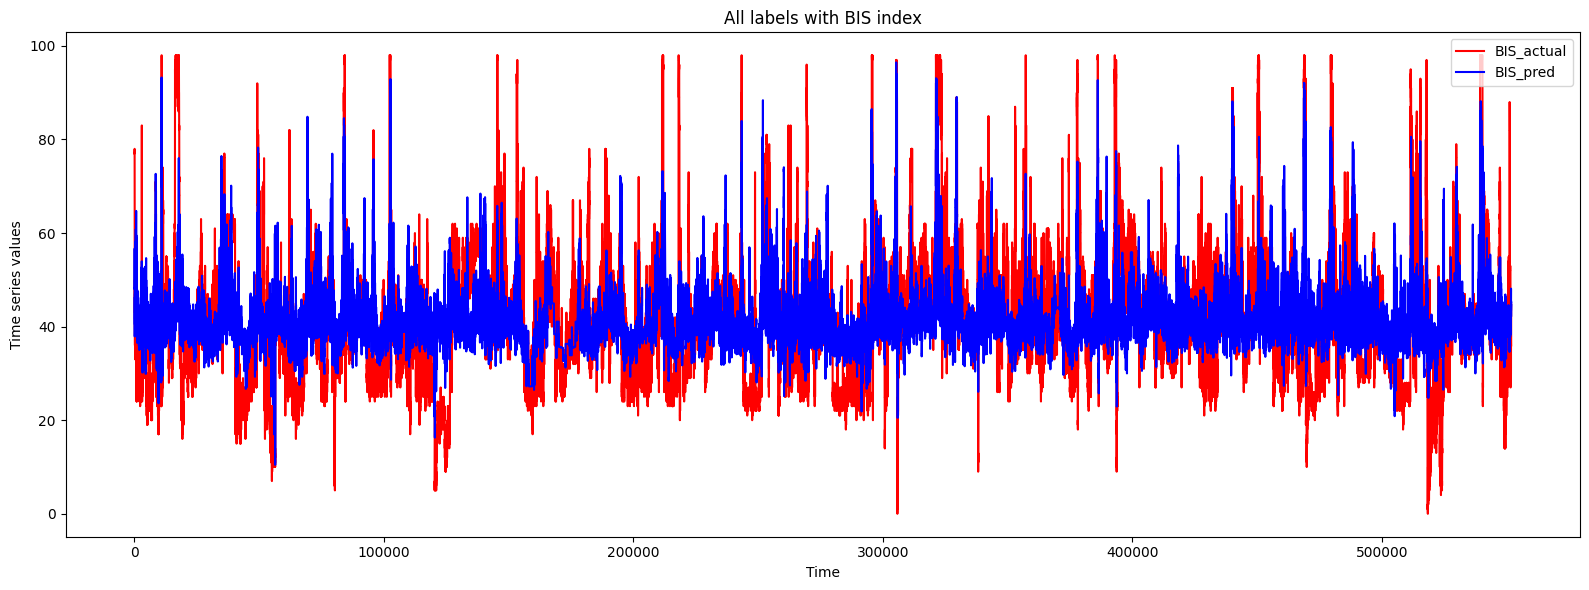

R2 score :  -0.01748925586263006
MAE for fold  {2}  =  8.962018
__________________
TEST


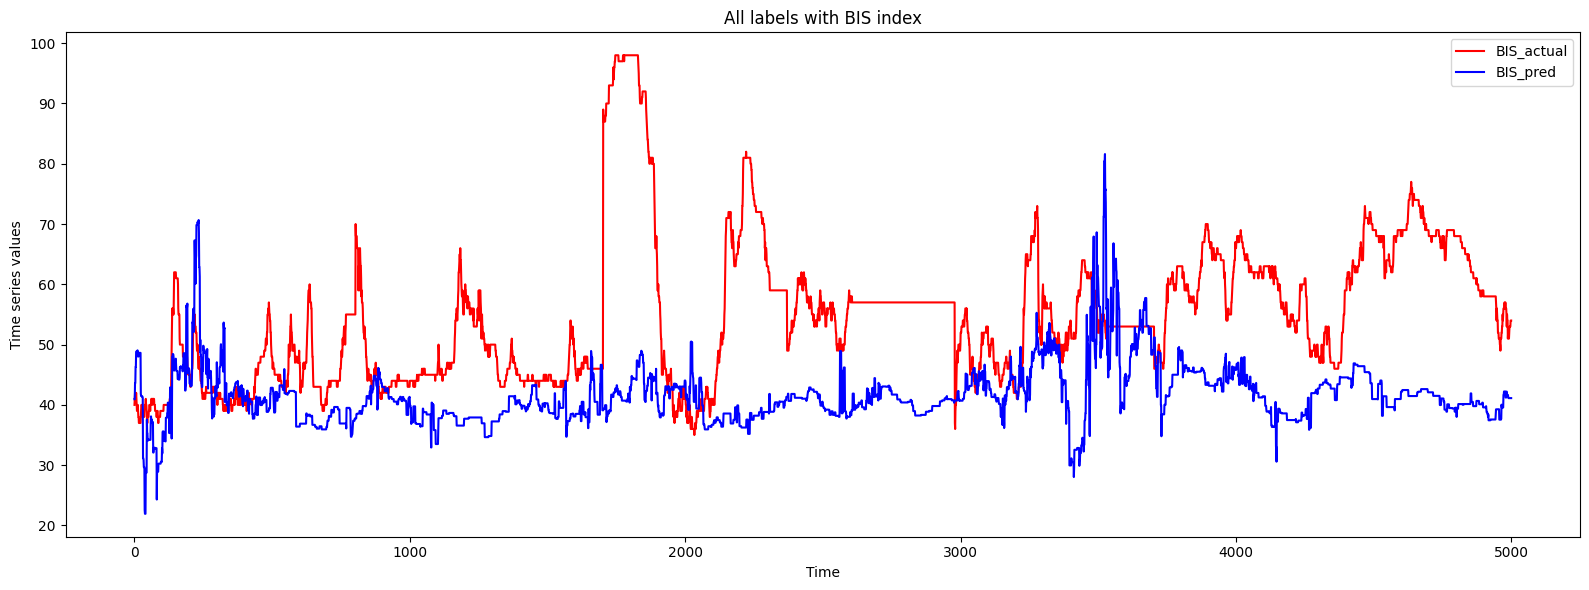

TOTAL


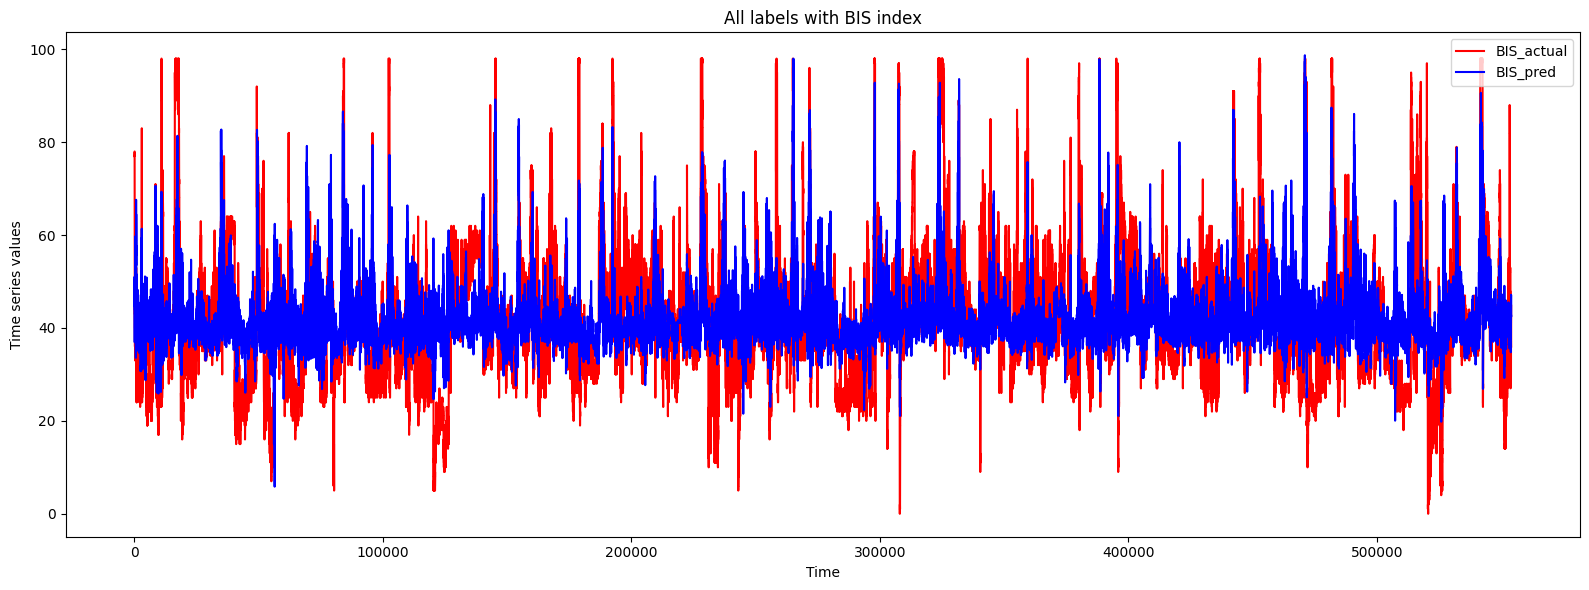

R2 score :  -0.08949884009604947
MAE for fold  {3}  =  9.352561
__________________
TEST


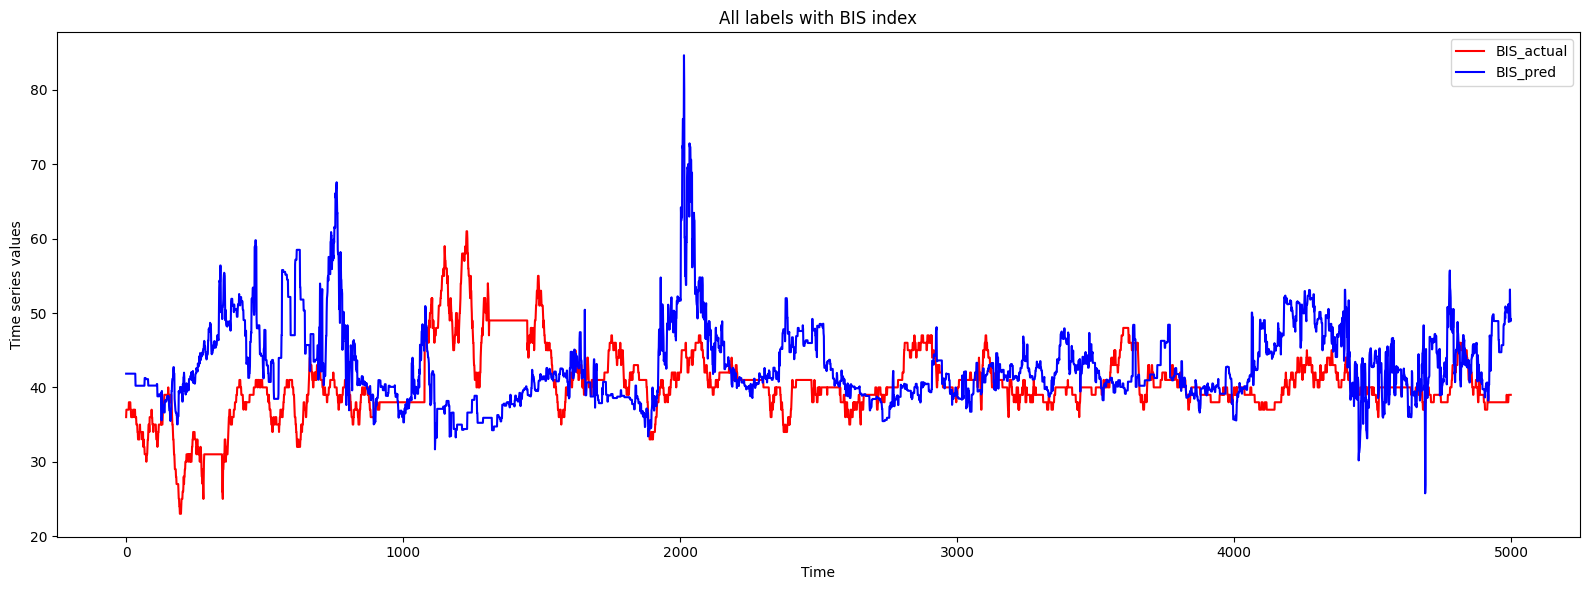

TOTAL


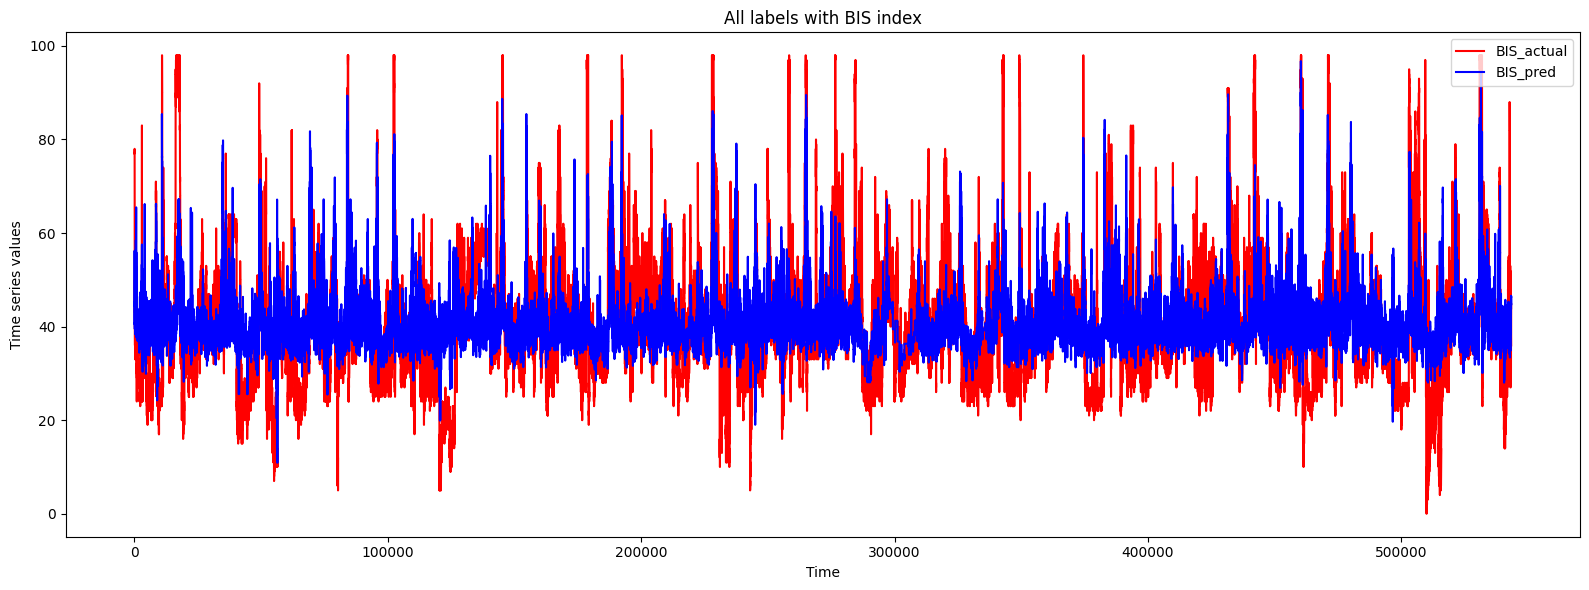

R2 score :  -0.09413038439387611
MAE for fold  {4}  =  10.574367
__________________
TEST


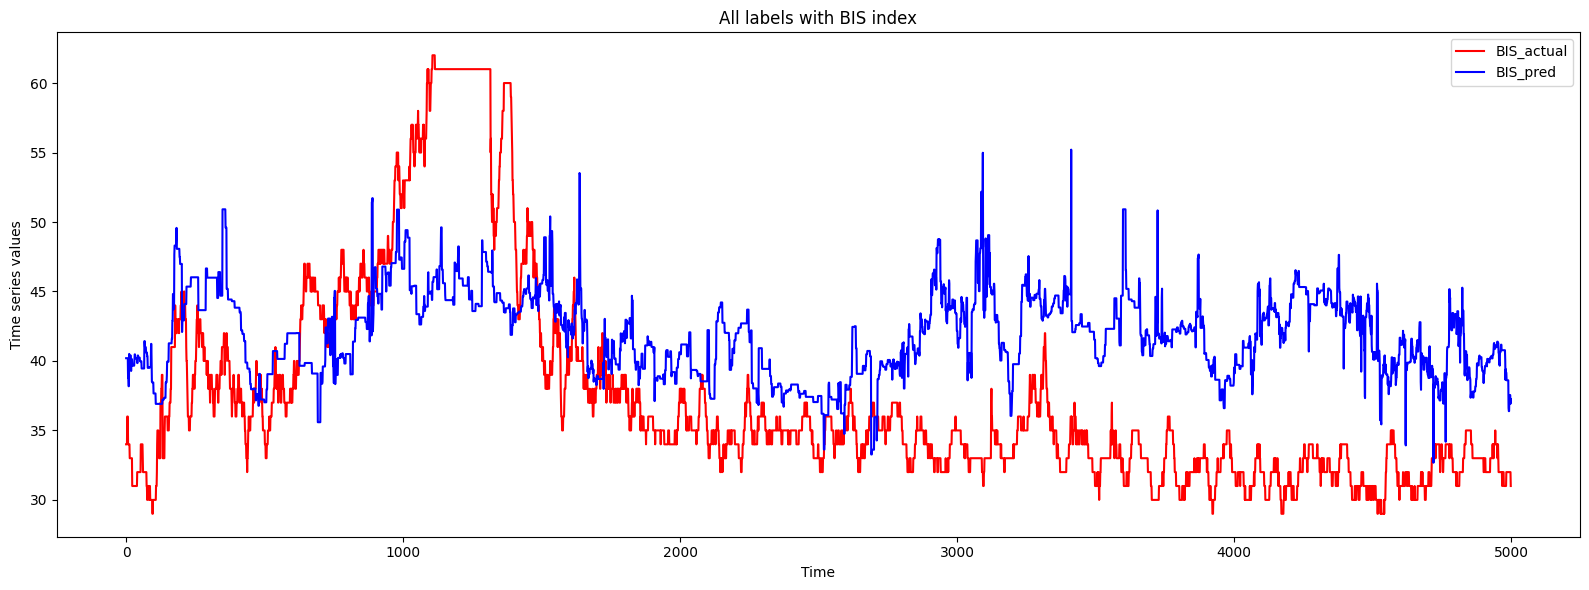

TOTAL


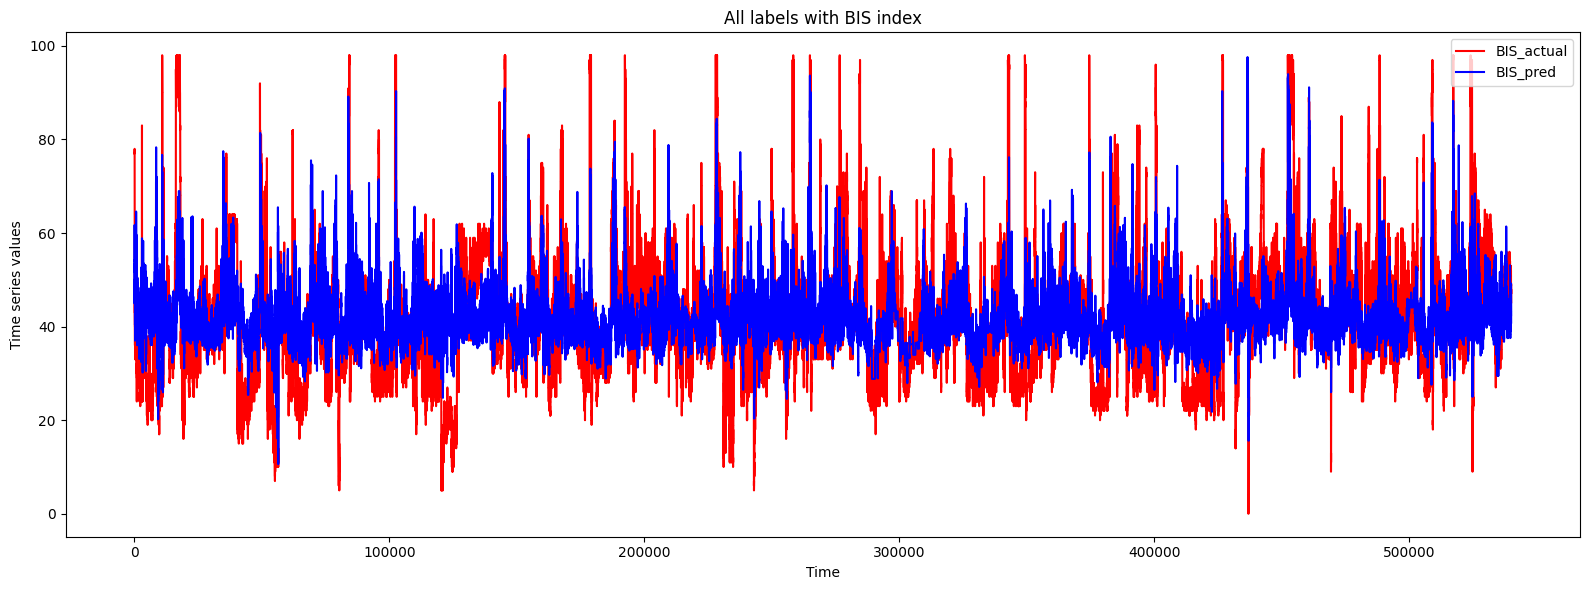

R2 score :  -0.019038875034220304
MAE for fold  {5}  =  10.945041
__________________
AVG MAE trained on pnim  10.367098808288574


In [40]:
mae = 0
k = 5

i = 0
while i < k:
    testli = data[i]
    j = 0
    trainli = []
    while j < k:
        if (j == i):
            pass
        else:
            trainli = trainli + data[j]
        j = j+1
    
    testdf = pd.concat(testli, axis=0, ignore_index=True)
    traindf = pd.concat(trainli, axis=0, ignore_index=True)

    bis_t,pnim_t,fc_t,spo2_t,co2_t = generate_arrays(testdf)
    bis,pnim,fc,spo2,co2 = generate_arrays(traindf)

    mae_ = calcmse3(bis, pnim, bis_t, pnim_t, width=100, want_to_print = True, n_estim=100)
    mae = mae + mae_
    
    print("MAE for fold ", {i+1}, " = ",  mae_)
    print("__________________")

    i = i+1

print("AVG MAE trained on pnim ", mae/k)



TEST


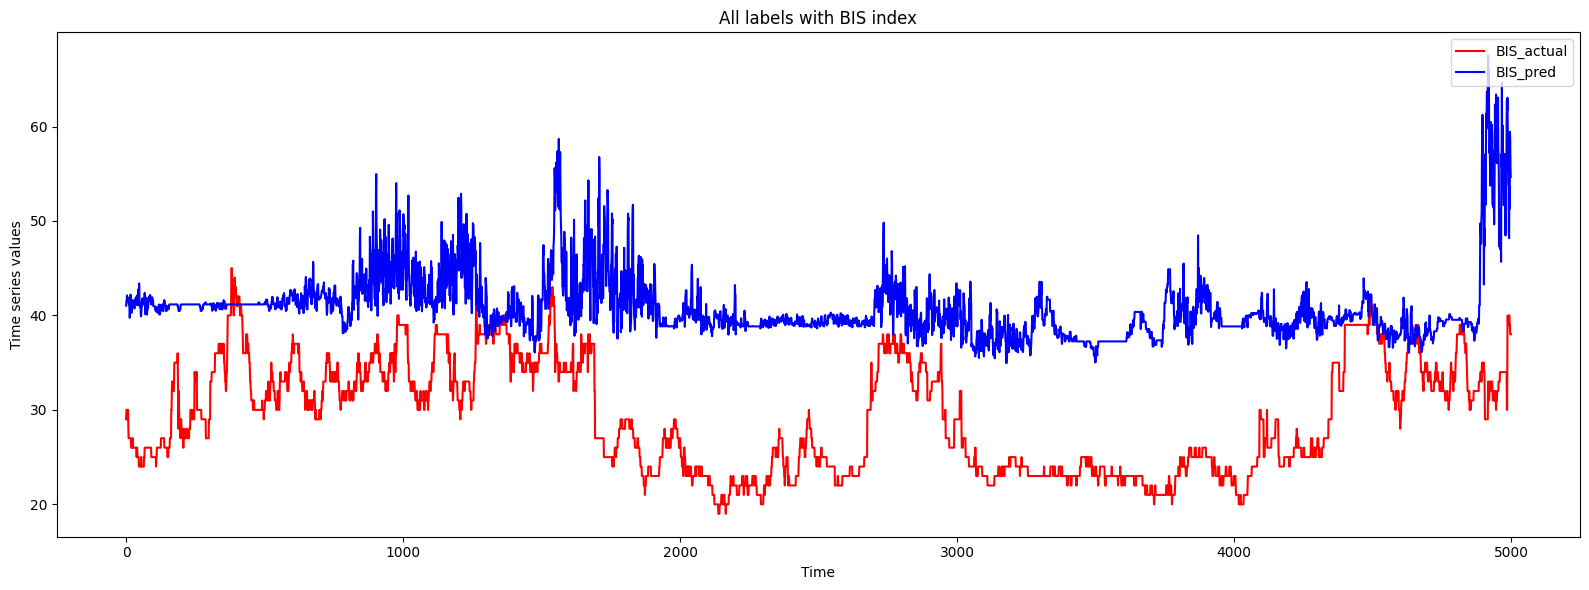

TOTAL


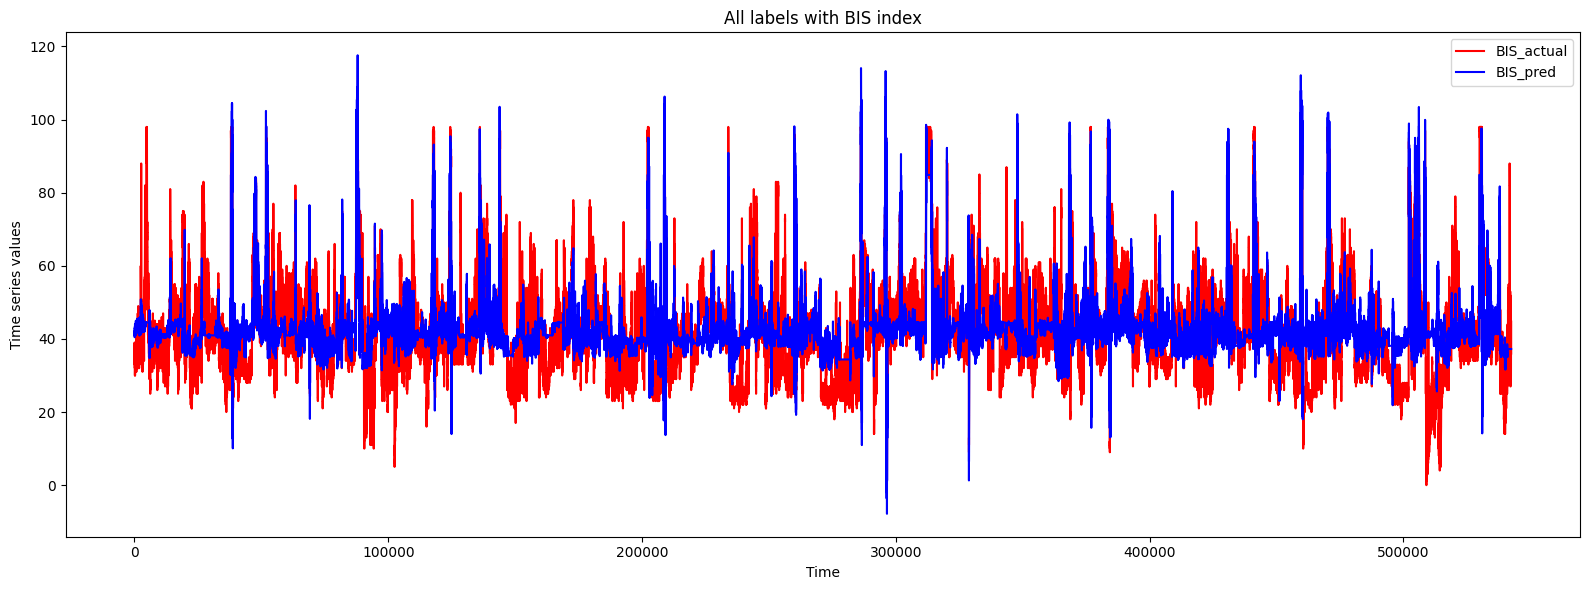

R2 score :  0.174926097493469
MAE for fold  {1}  =  10.571849
__________________
TEST


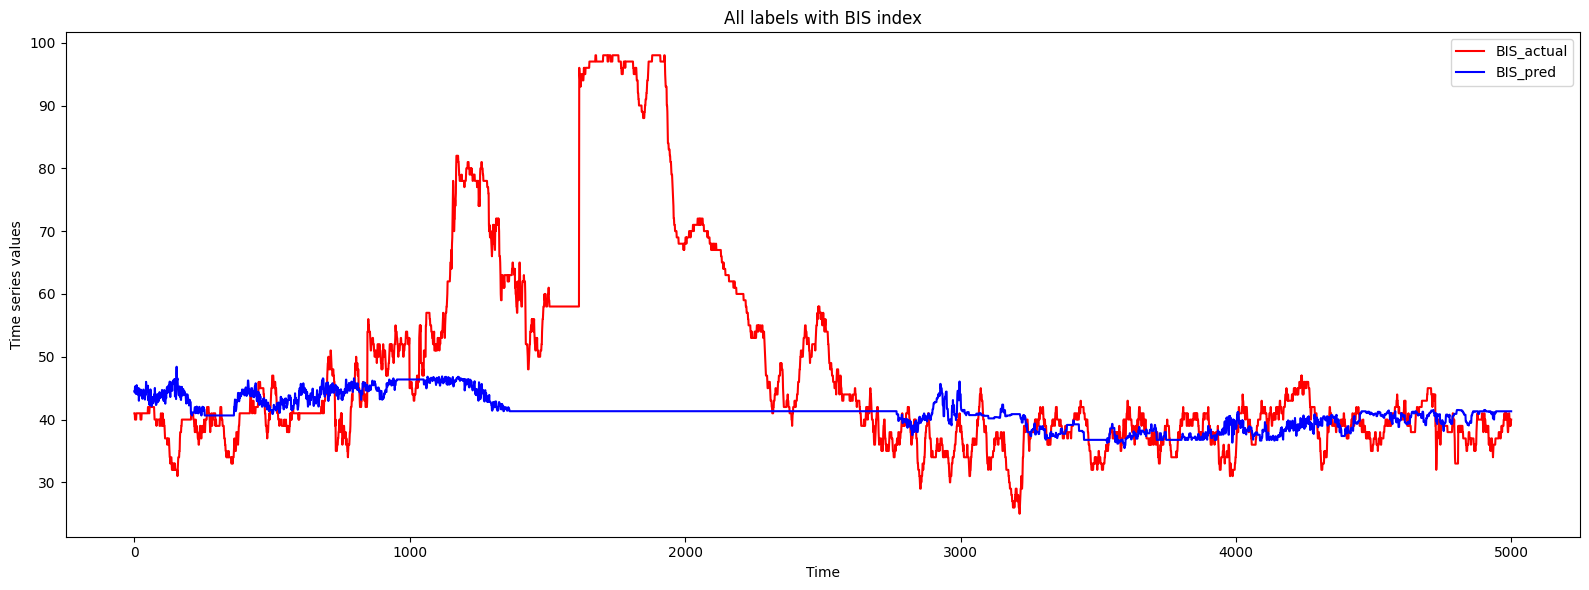

TOTAL


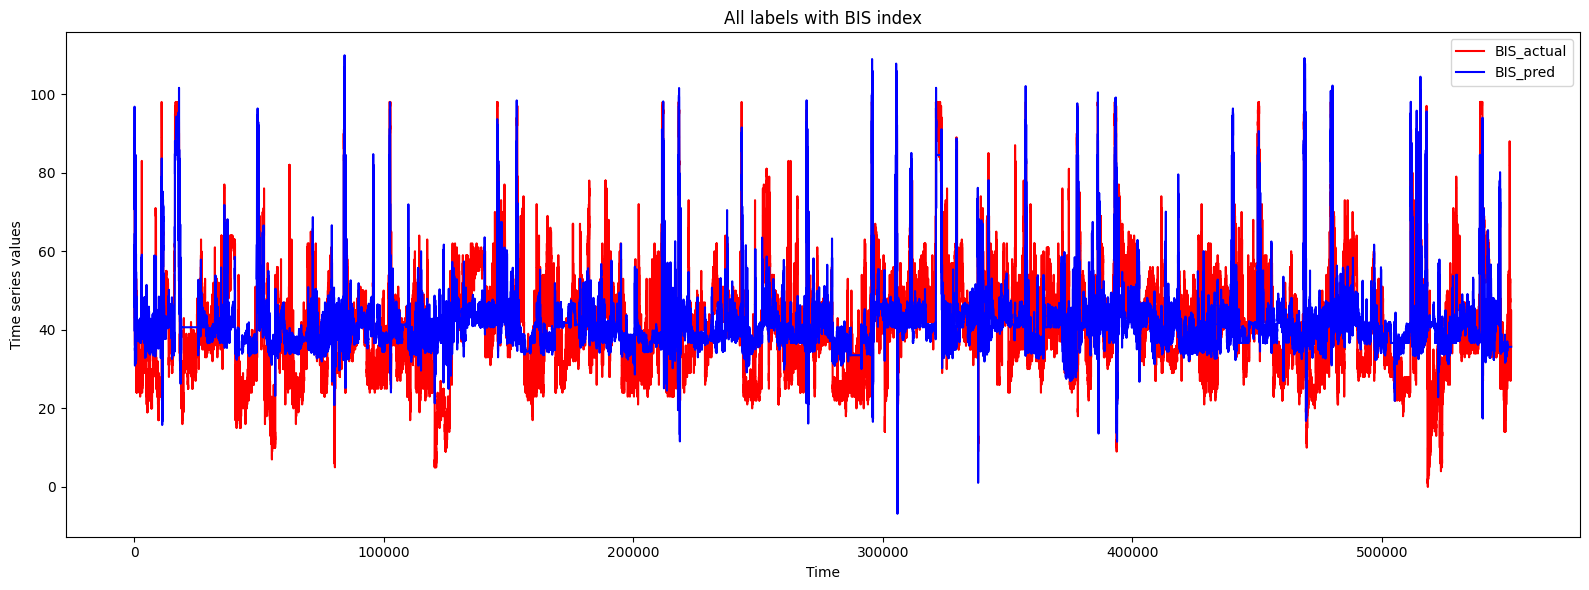

R2 score :  0.16484885220638323
MAE for fold  {2}  =  8.41395
__________________
TEST


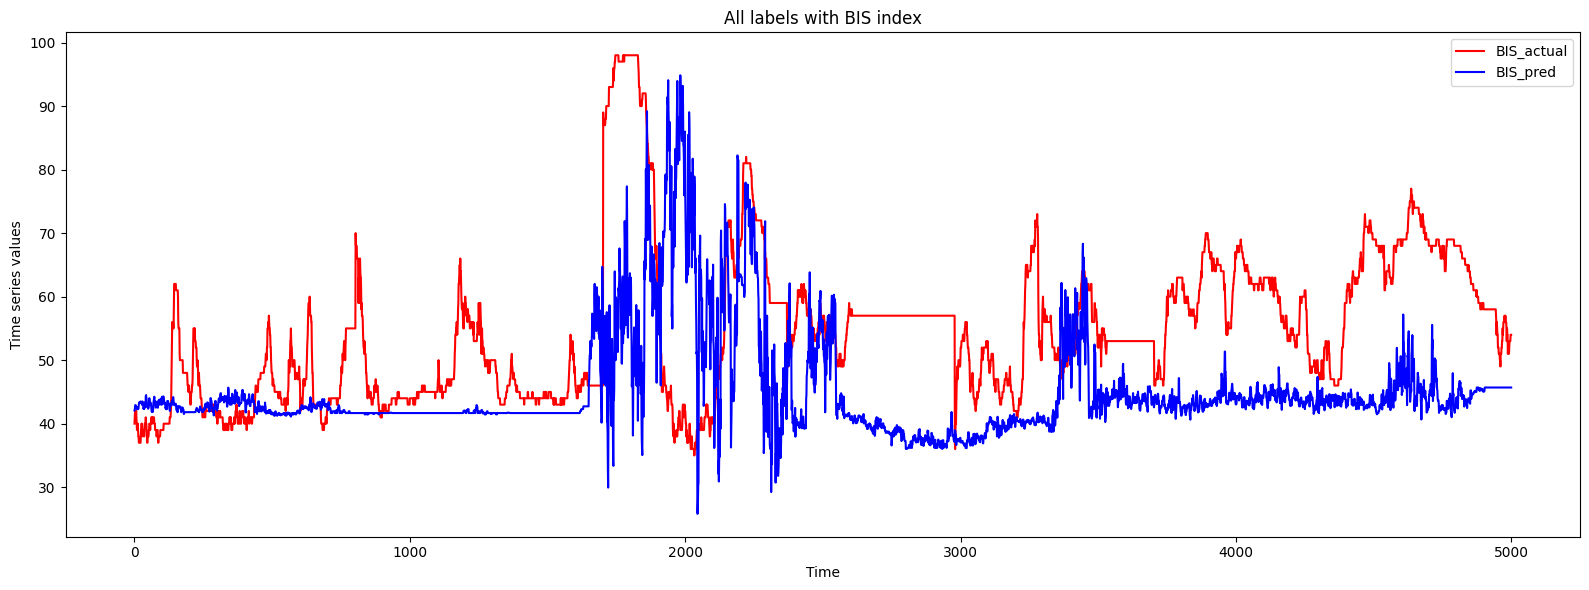

TOTAL


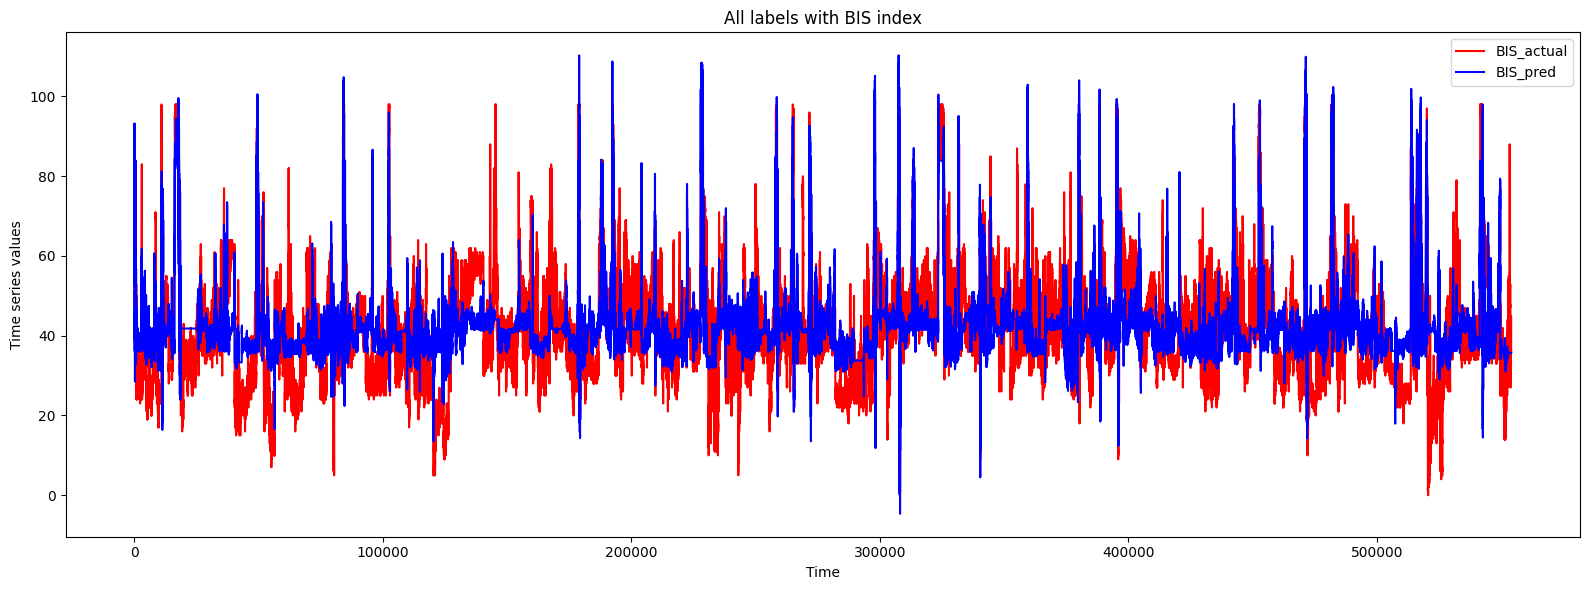

R2 score :  0.05207672468009639
MAE for fold  {3}  =  8.9122715
__________________
TEST


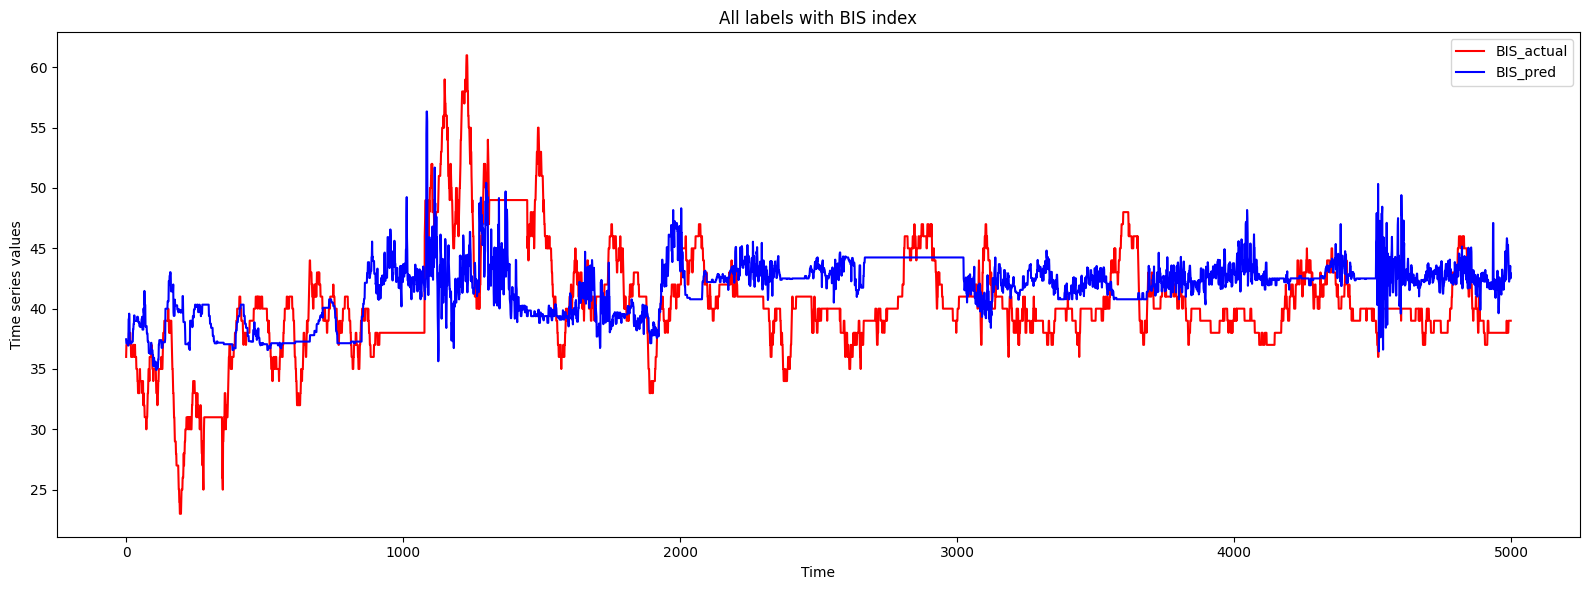

TOTAL


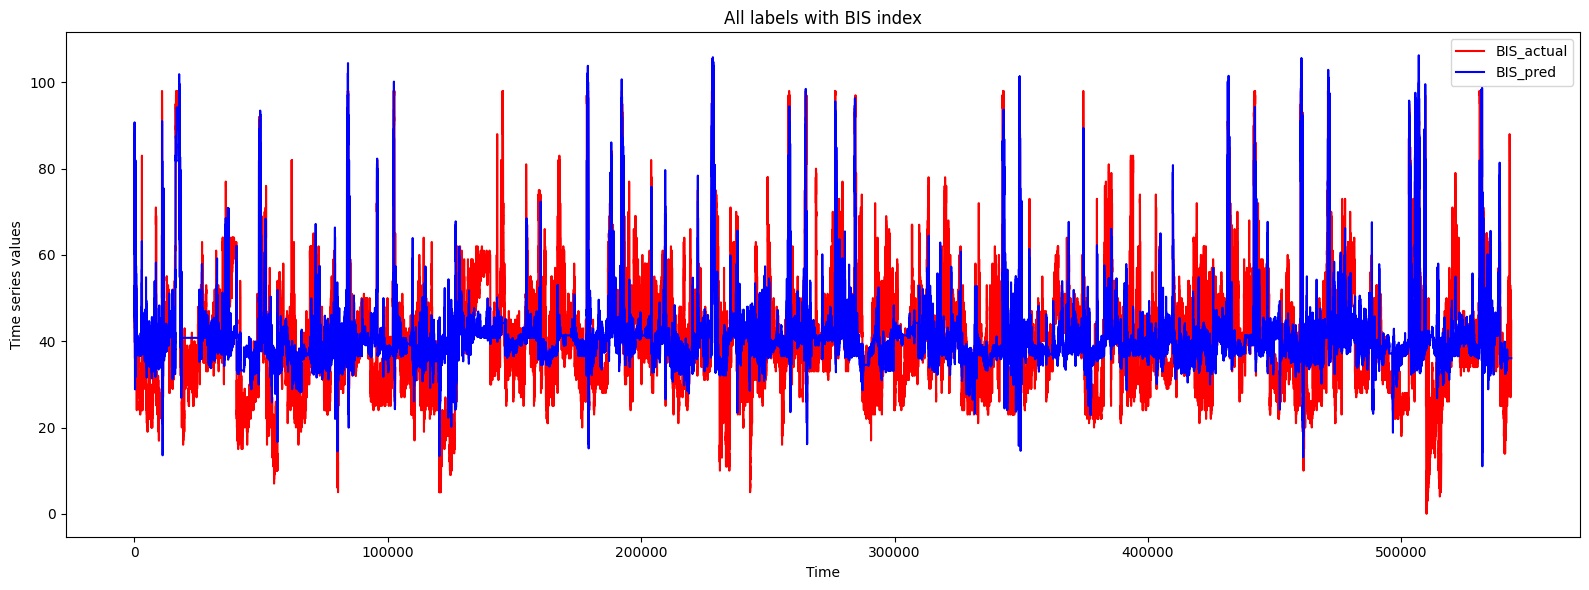

R2 score :  0.06681325672731186
MAE for fold  {4}  =  10.076284
__________________
TEST


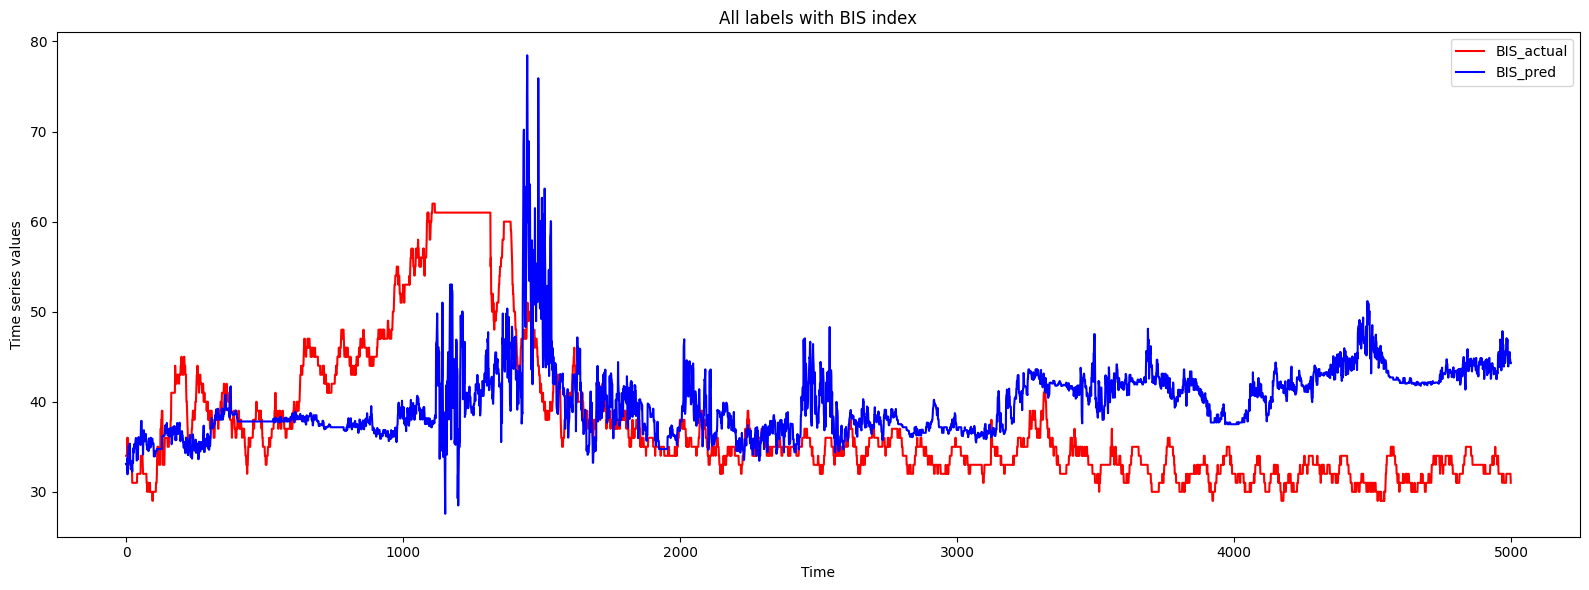

TOTAL


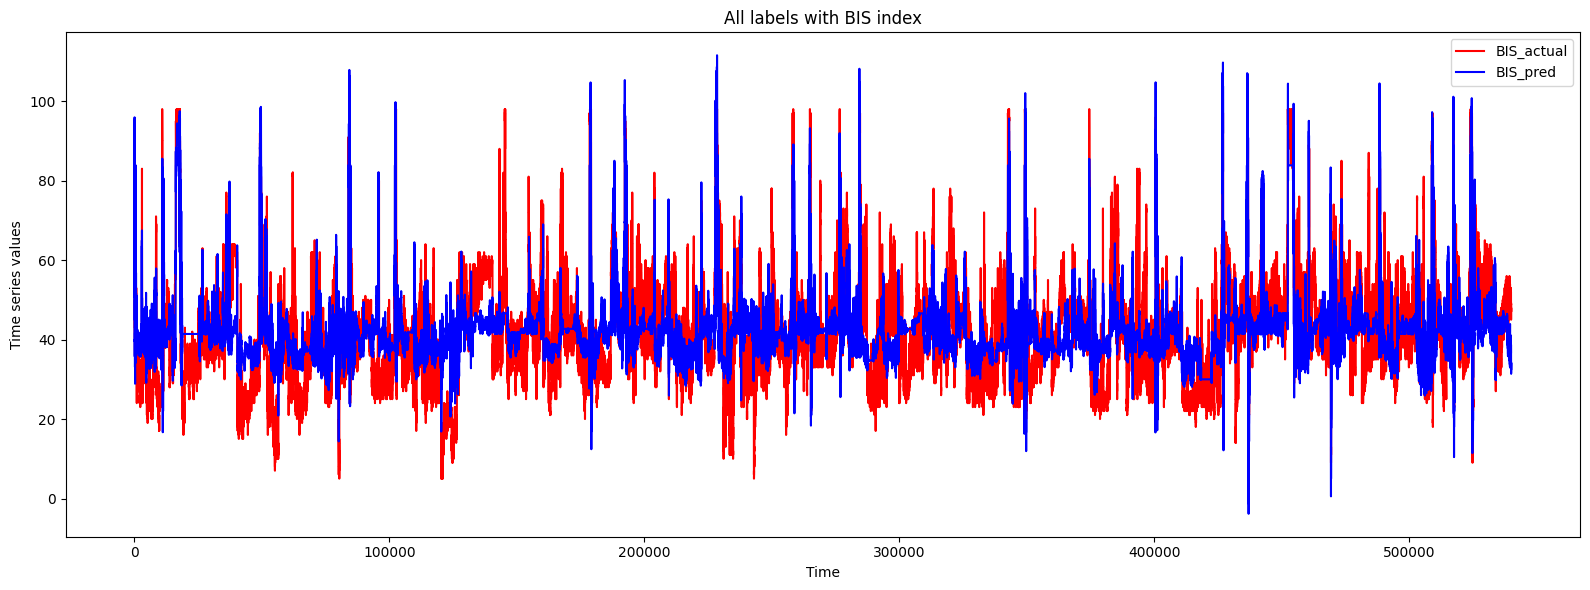

R2 score :  0.1800388569003849
MAE for fold  {5}  =  10.151714
__________________
AVG MAE trained on co2  9.625213813781738


In [41]:
mae = 0
k = 5

i = 0
while i < k:
    testli = data[i]
    j = 0
    trainli = []
    while j < k:
        if (j == i):
            pass
        else:
            trainli = trainli + data[j]
        j = j+1
    
    testdf = pd.concat(testli, axis=0, ignore_index=True)
    traindf = pd.concat(trainli, axis=0, ignore_index=True)

    bis_t,pnim_t,fc_t,spo2_t,co2_t = generate_arrays(testdf)
    bis,pnim,fc,spo2,co2 = generate_arrays(traindf)

    mae_ = calcmse3(bis, co2, bis_t,co2_t,width=100, want_to_print = True, n_estim=100)
    mae = mae + mae_
    
    print("MAE for fold ", {i+1}, " = ",  mae_)
    print("__________________")

    i = i+1

print("AVG MAE trained on co2 ", mae/k)



TEST


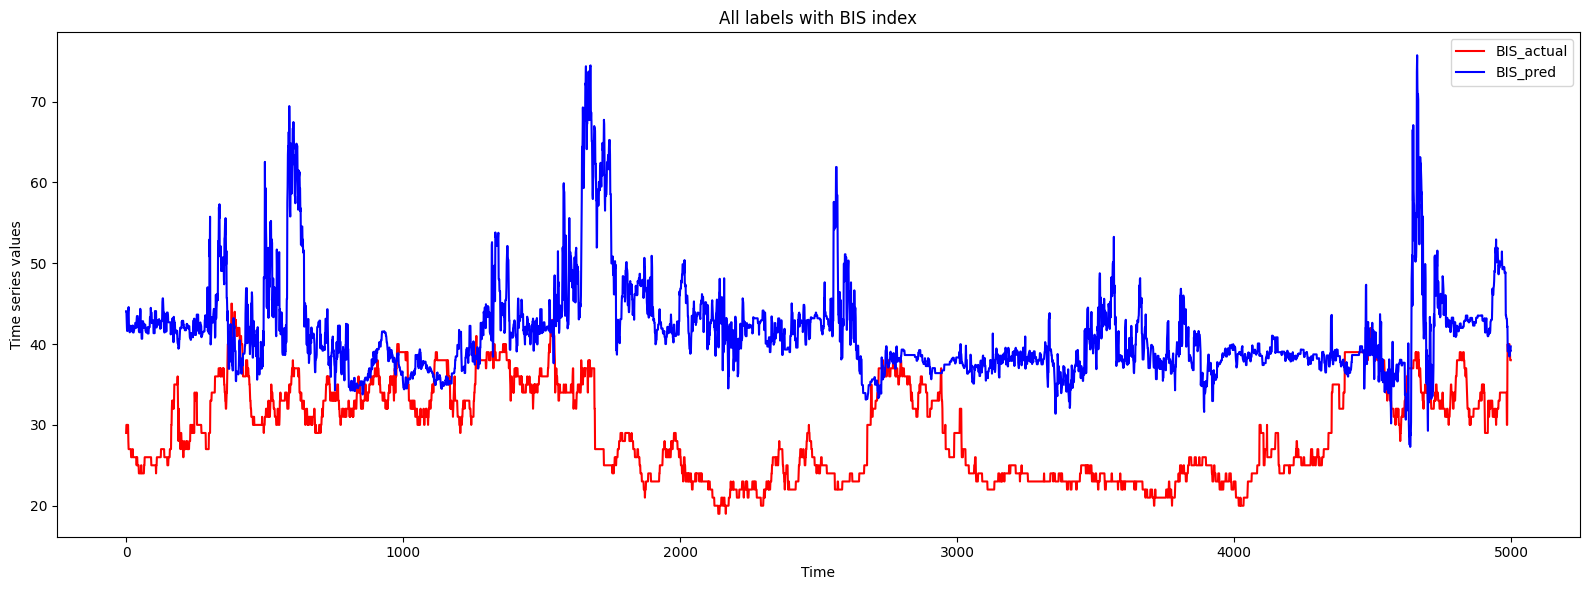

TOTAL


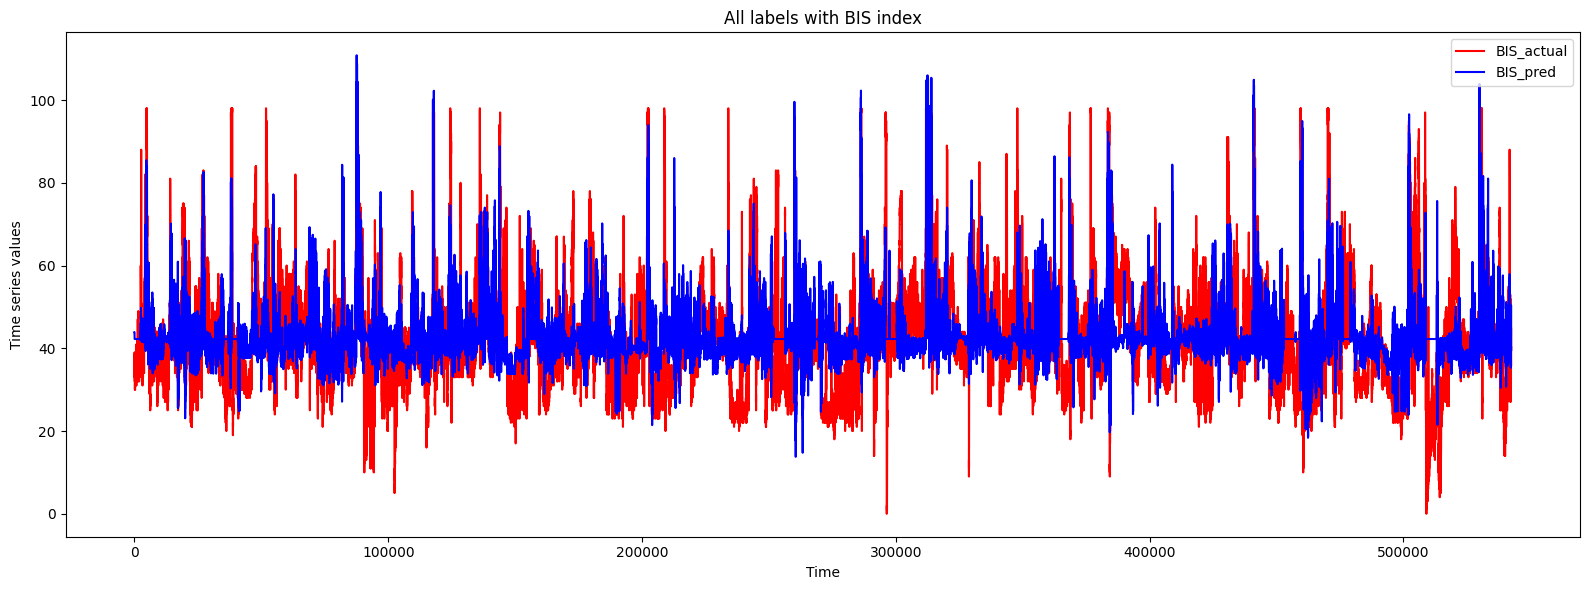

R2 score :  -0.07870400400777289
MAE for fold  {1}  =  11.760621
__________________
TEST


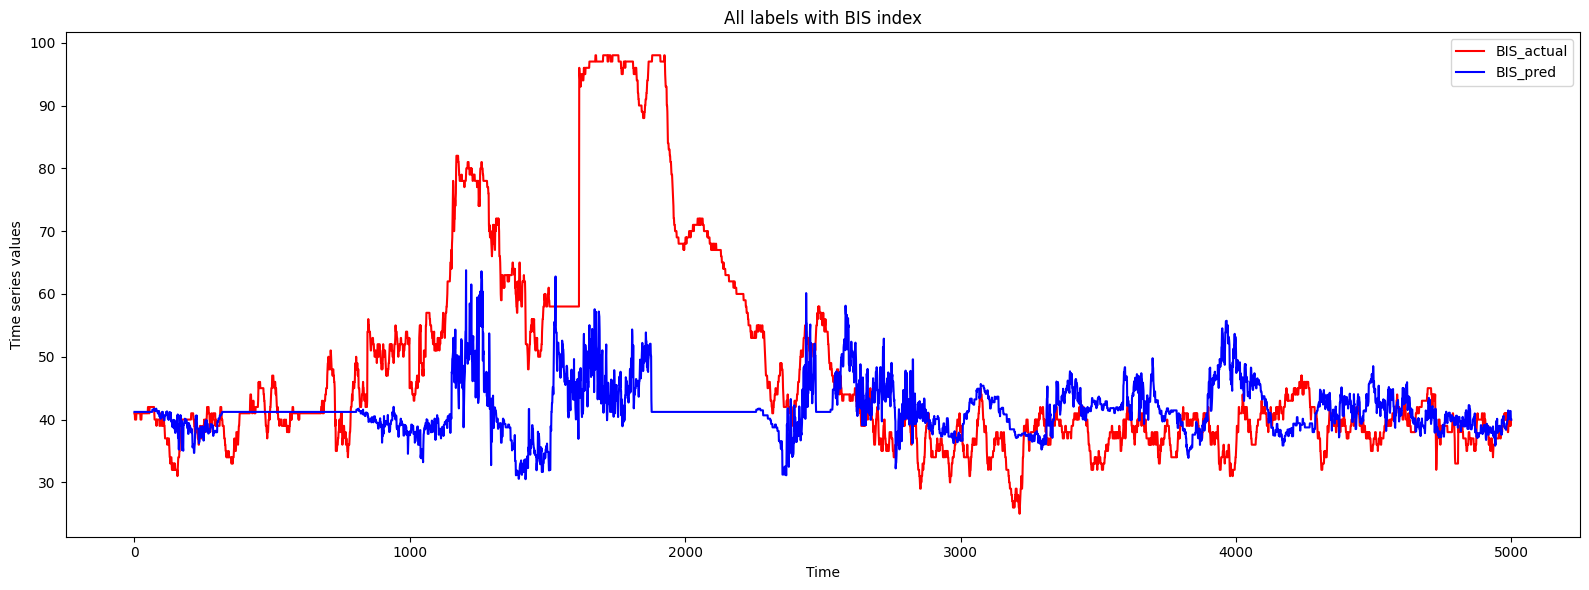

TOTAL


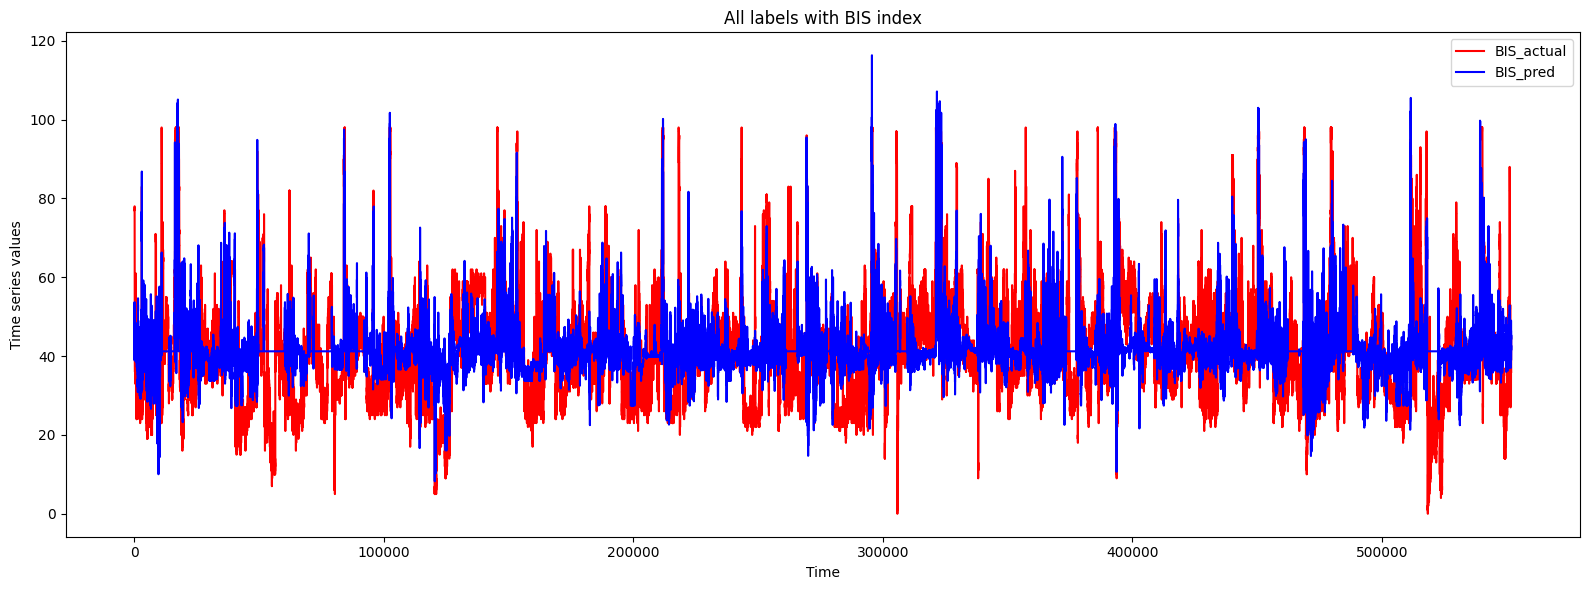

R2 score :  -0.026410341176094976
MAE for fold  {2}  =  9.178315
__________________
TEST


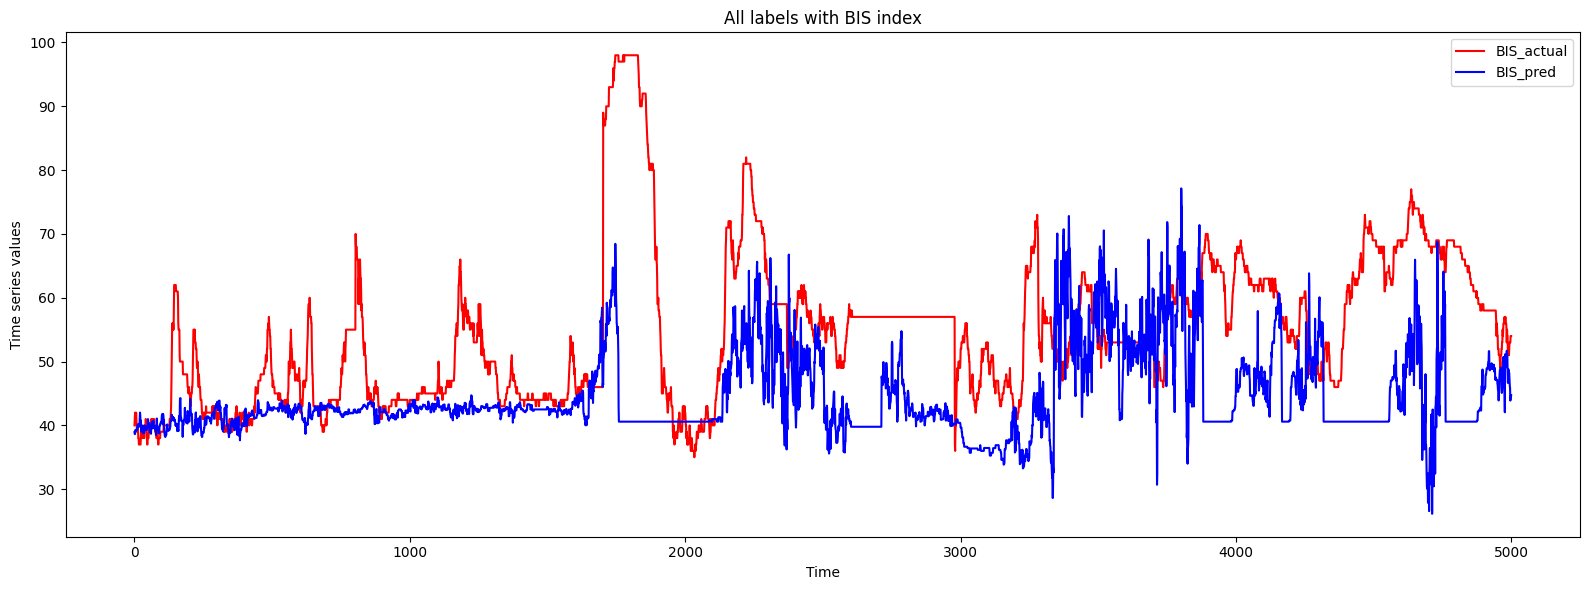

TOTAL


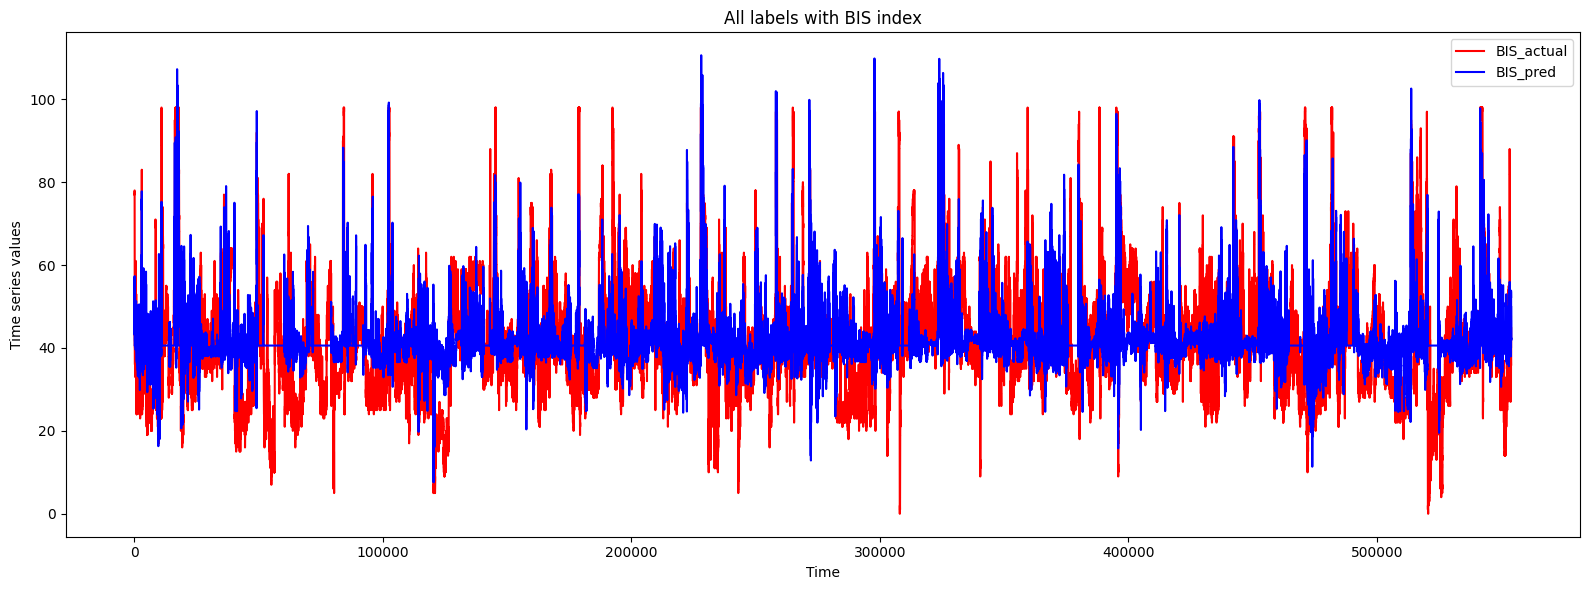

R2 score :  0.017630757276690057
MAE for fold  {3}  =  8.997138
__________________
TEST


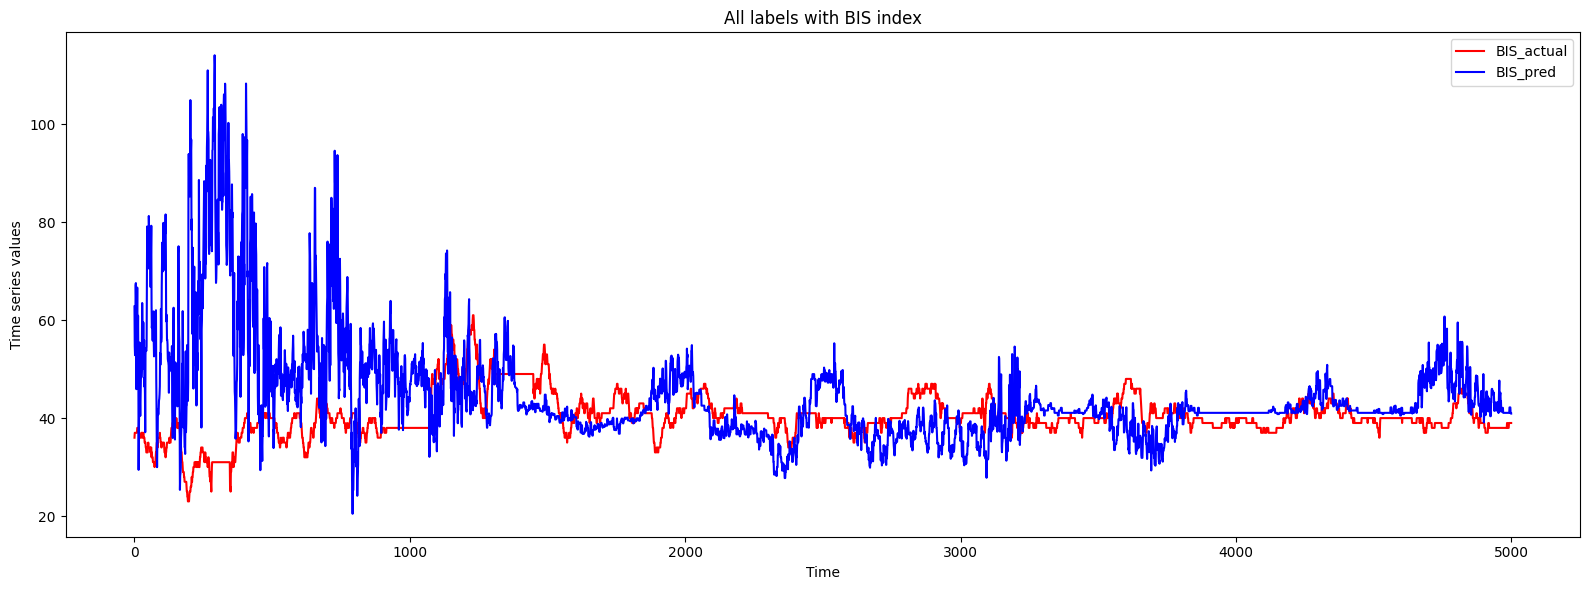

TOTAL


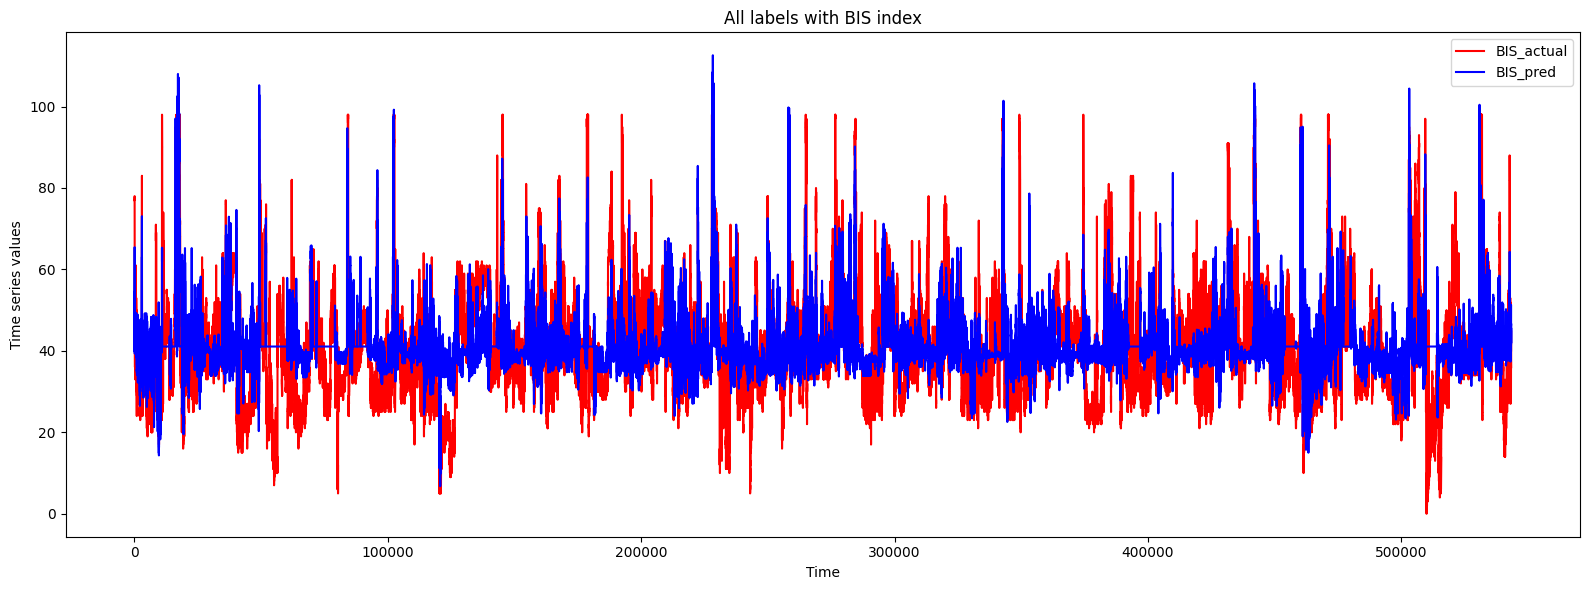

R2 score :  -0.19485892397103655
MAE for fold  {4}  =  11.184547
__________________
TEST


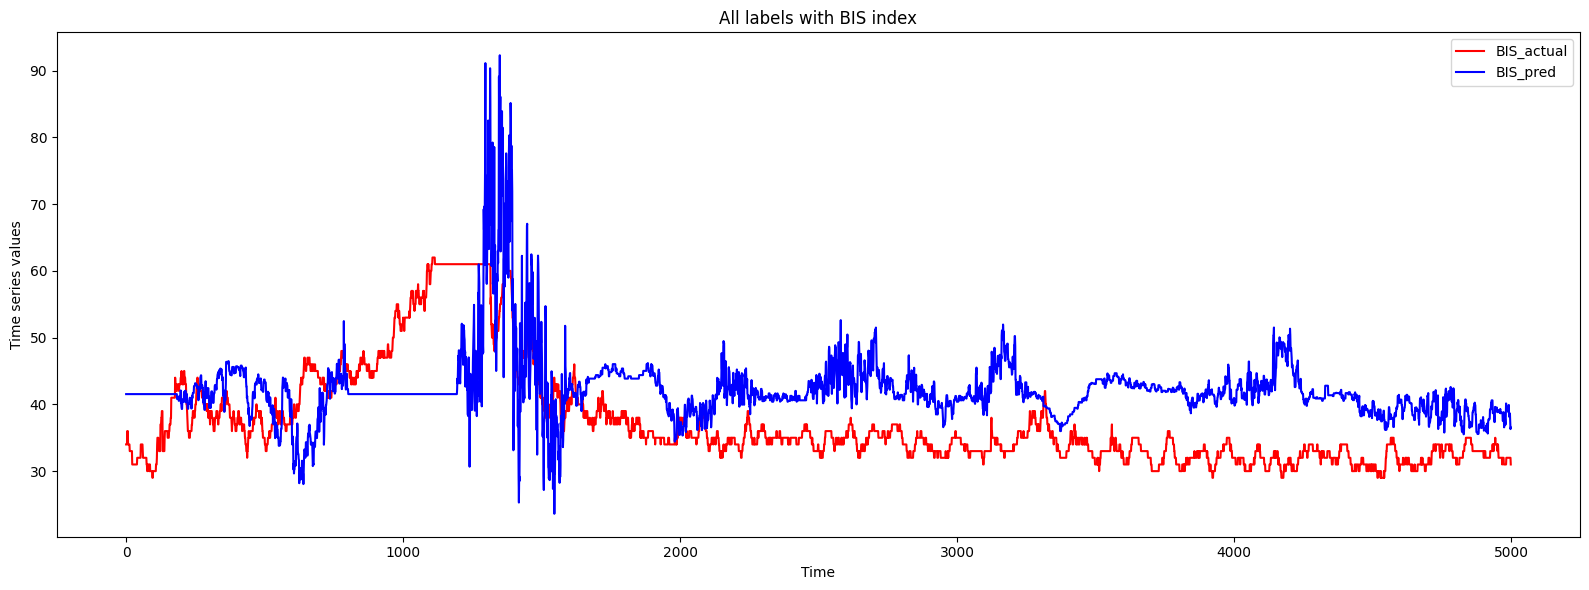

TOTAL


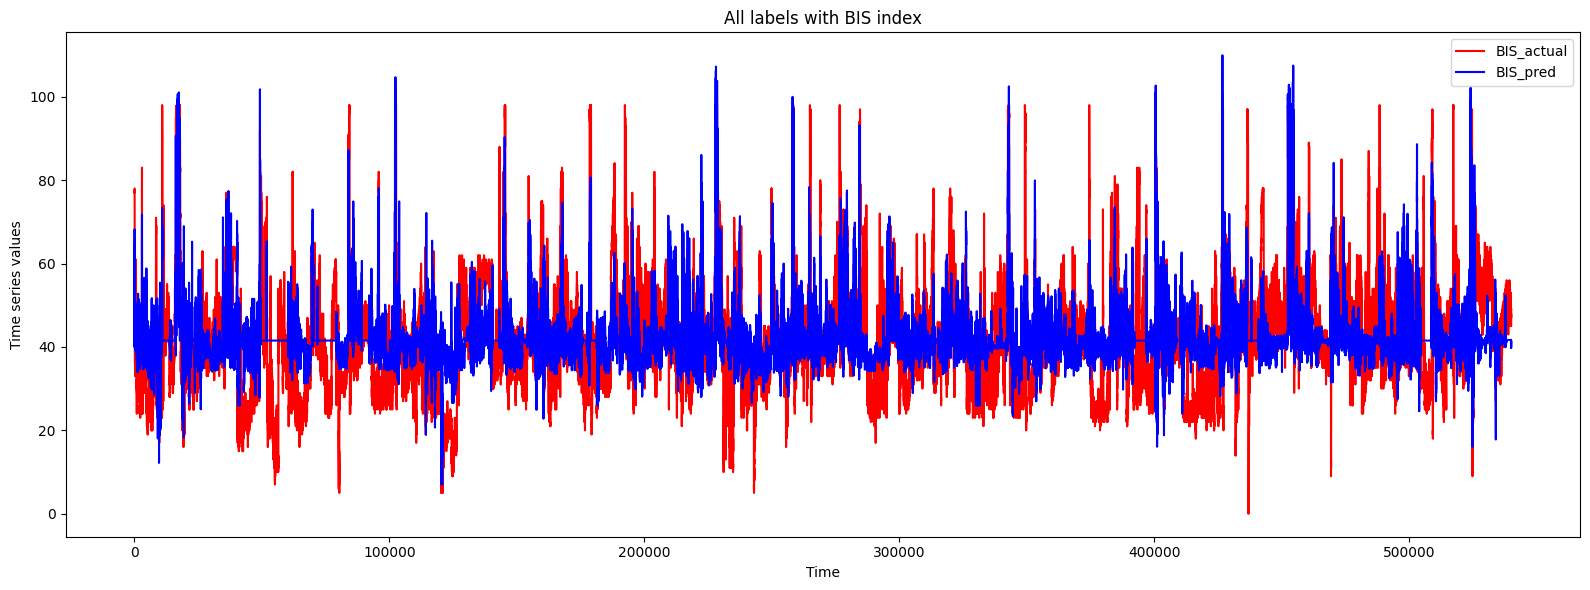

R2 score :  -0.012000191254188053
MAE for fold  {5}  =  10.641394
__________________
AVG MAE trained on spo2  10.35240306854248


In [42]:
mae = 0
k = 5

i = 0
while i < k:
    testli = data[i]
    j = 0
    trainli = []
    while j < k:
        if (j == i):
            pass
        else:
            trainli = trainli + data[j]
        j = j+1
    
    testdf = pd.concat(testli, axis=0, ignore_index=True)
    traindf = pd.concat(trainli, axis=0, ignore_index=True)

    bis_t,pnim_t,fc_t,spo2_t,co2_t = generate_arrays(testdf)
    bis,pnim,fc,spo2,co2 = generate_arrays(traindf)

    mae_ = calcmse3(bis, spo2, bis_t, spo2_t, width=100, want_to_print = True, n_estim=100)
    mae = mae + mae_
    
    print("MAE for fold ", {i+1}, " = ",  mae_)
    print("__________________")

    i = i+1

print("AVG MAE trained on spo2 ", mae/k)



TEST


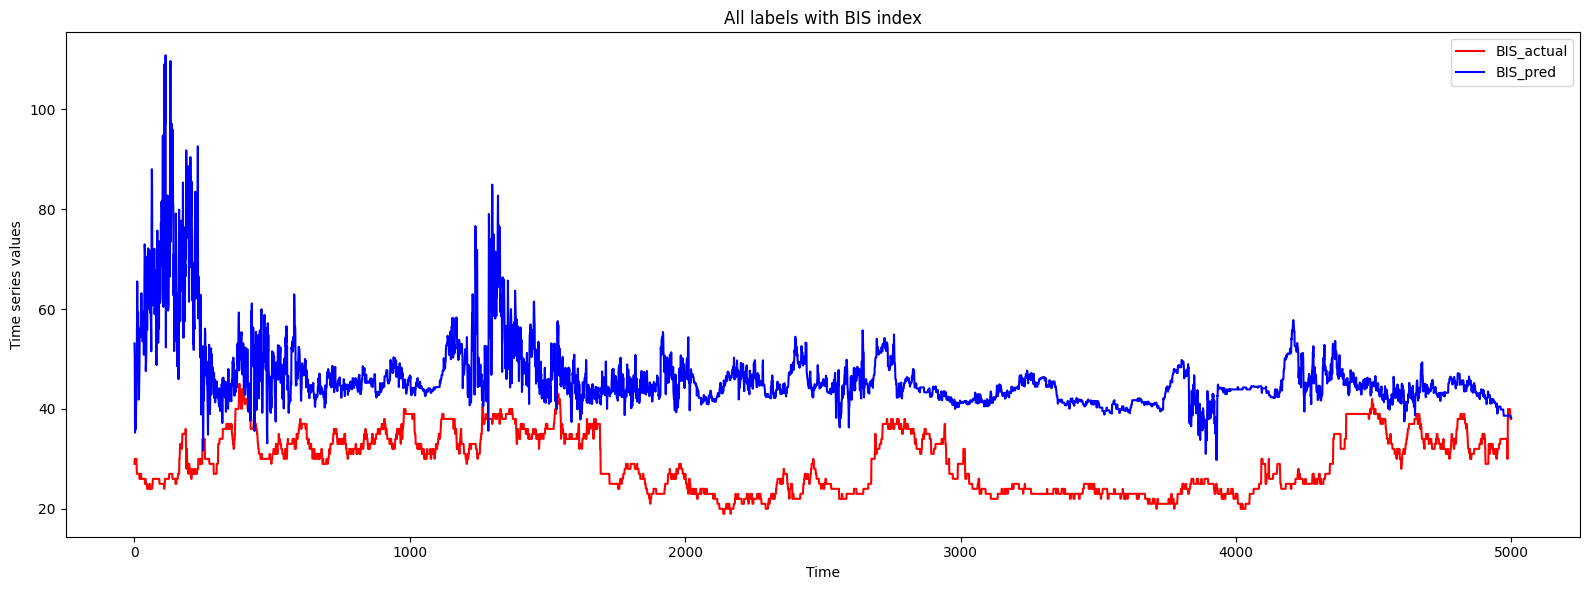

TOTAL


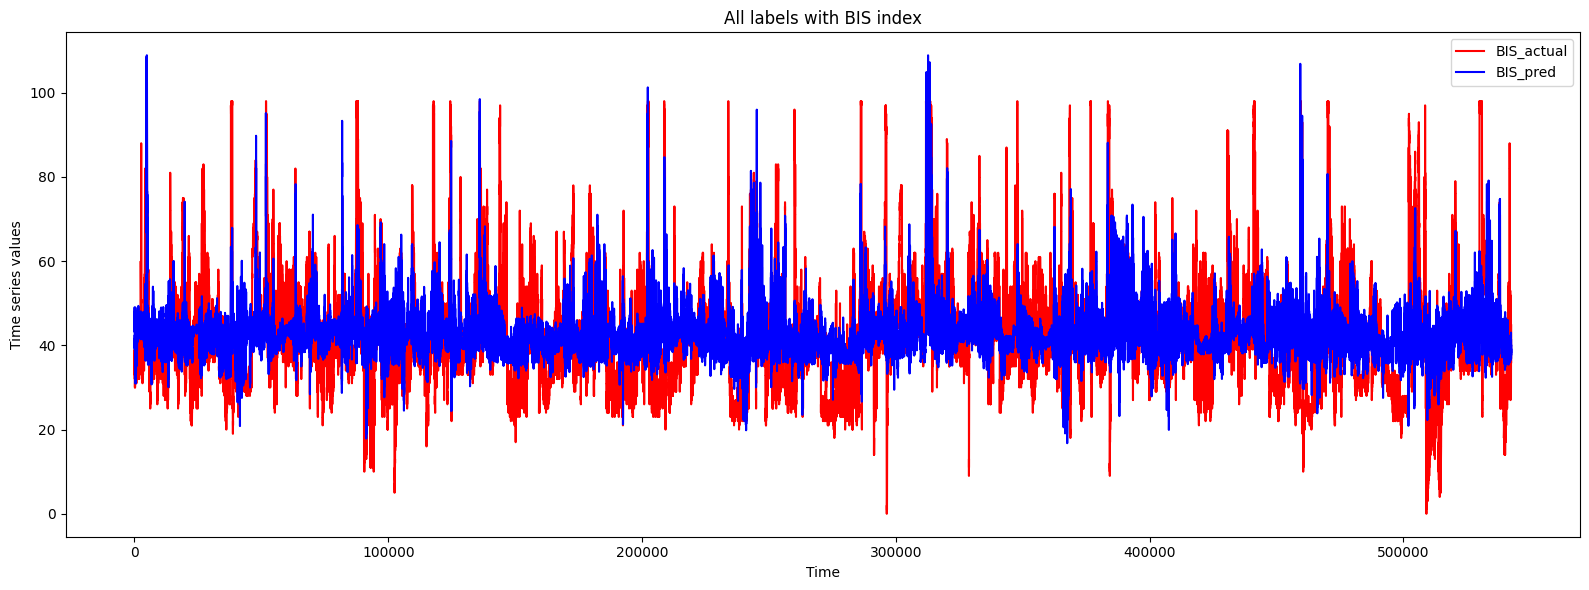

R2 score :  -0.12875835652320355
MAE for fold  {1}  =  12.071957
__________________
TEST


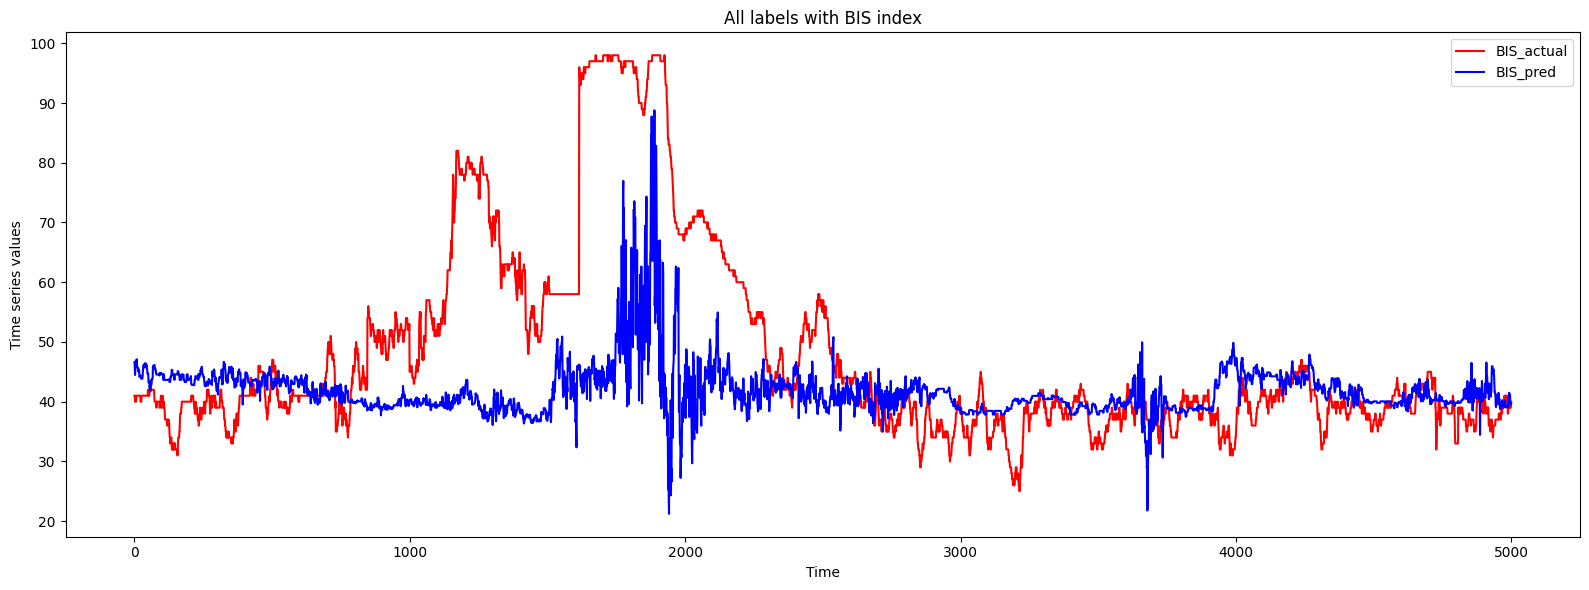

TOTAL


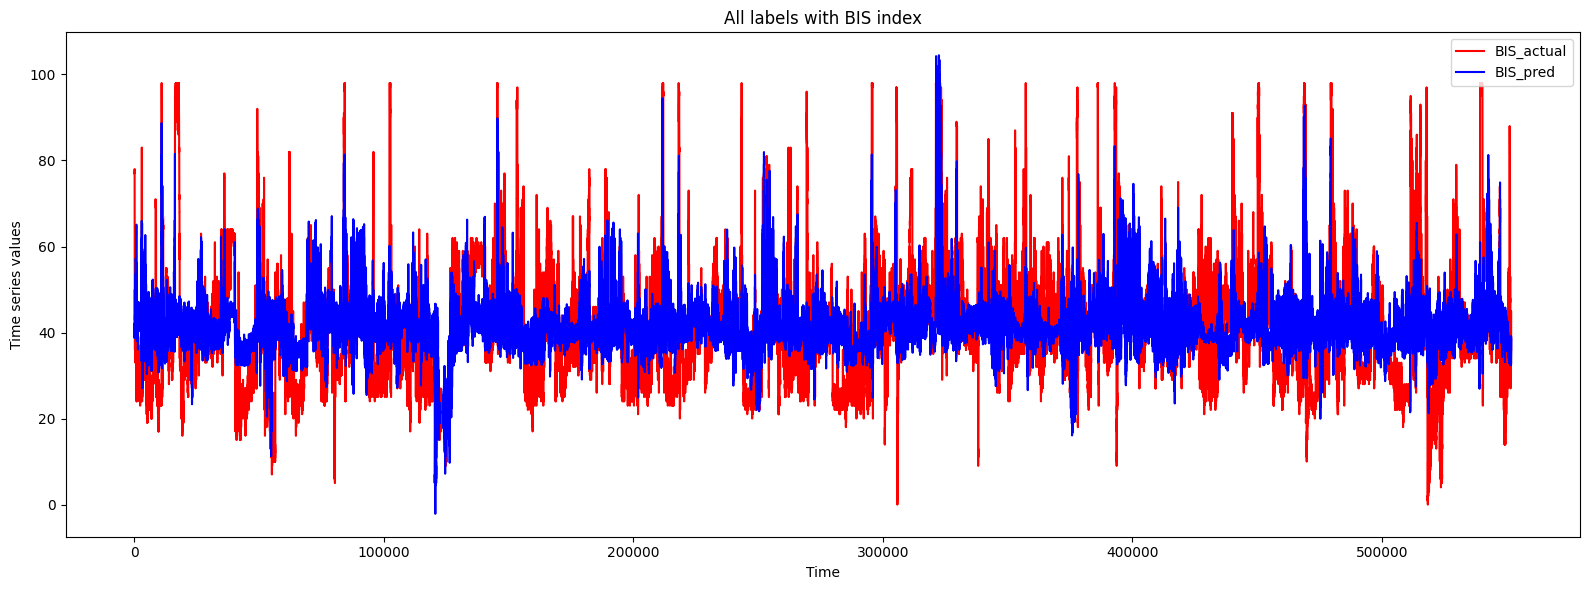

R2 score :  -0.0611921544134959
MAE for fold  {2}  =  9.224247
__________________
TEST


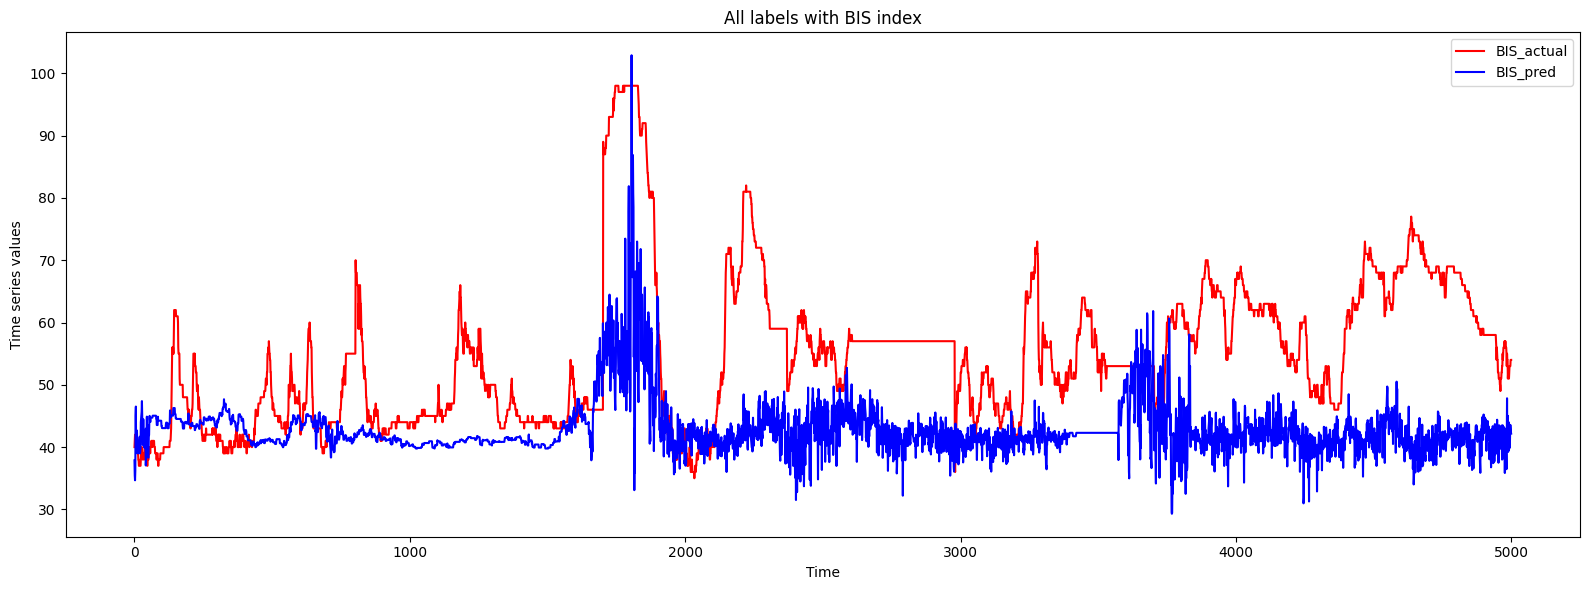

TOTAL


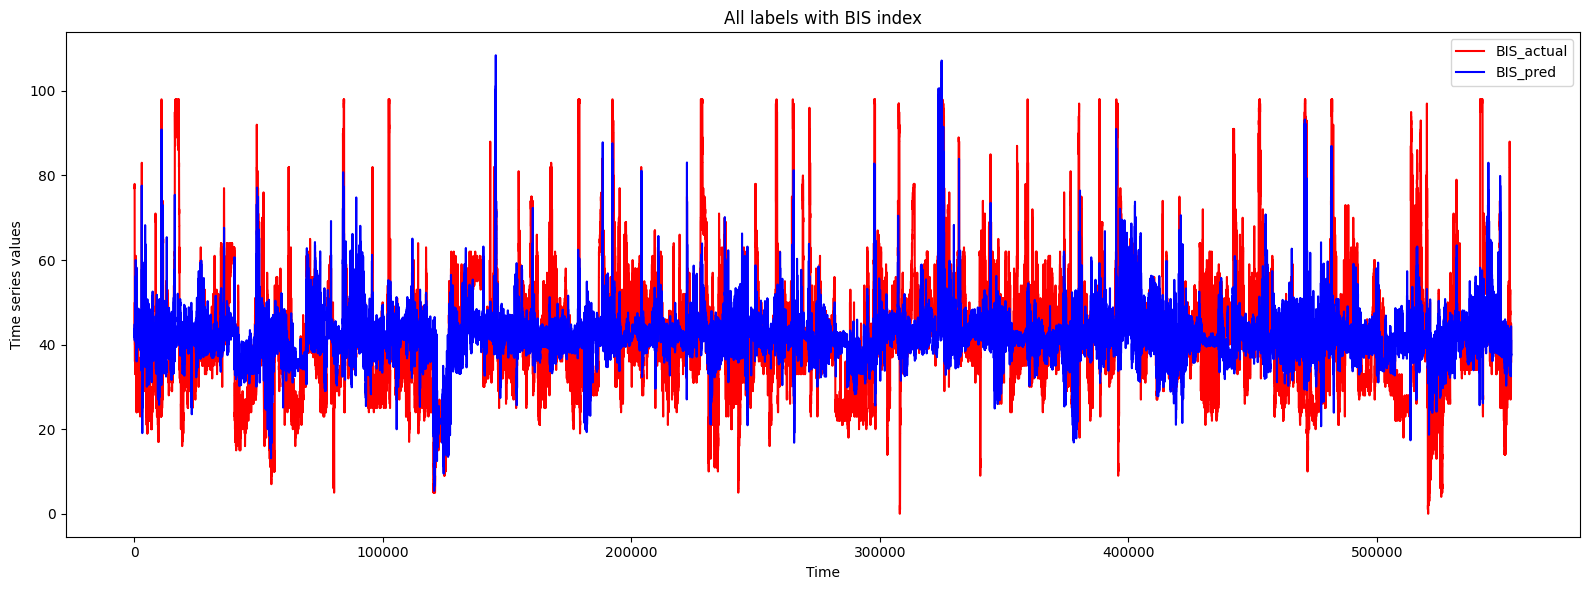

R2 score :  -0.07119017691955709
MAE for fold  {3}  =  9.401333
__________________
TEST


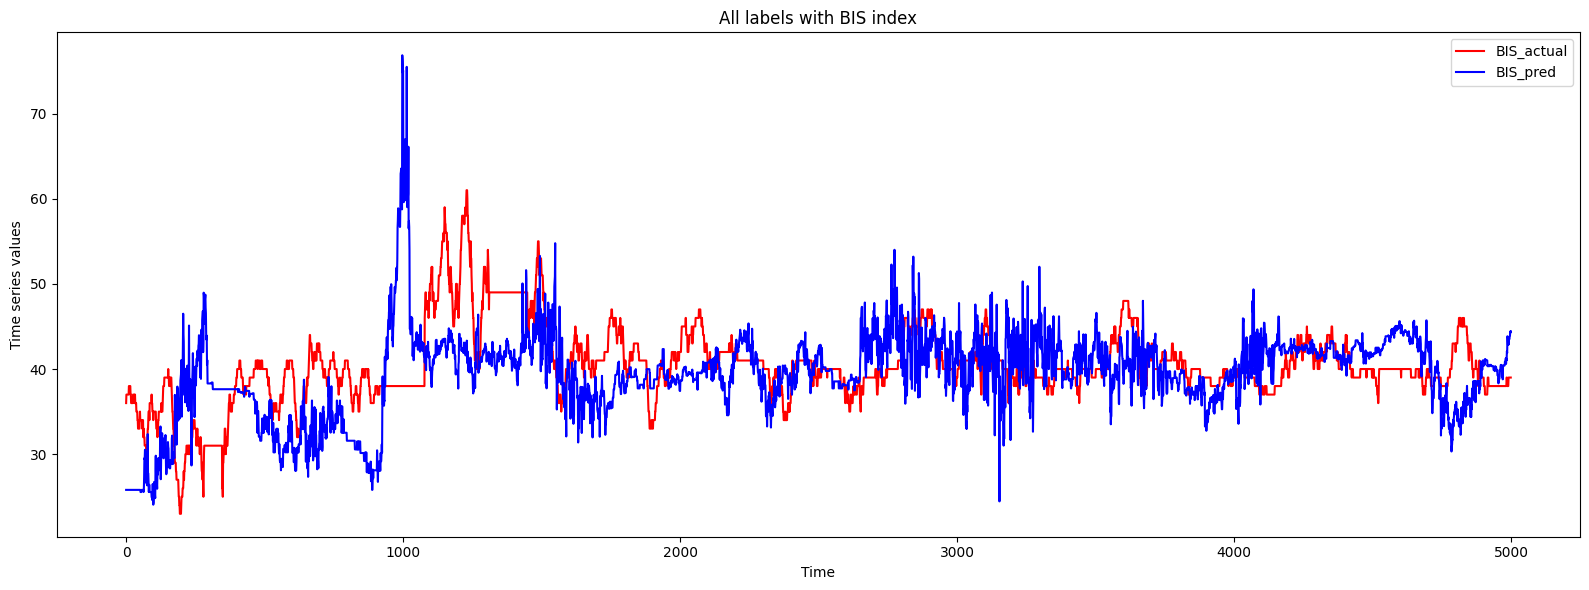

TOTAL


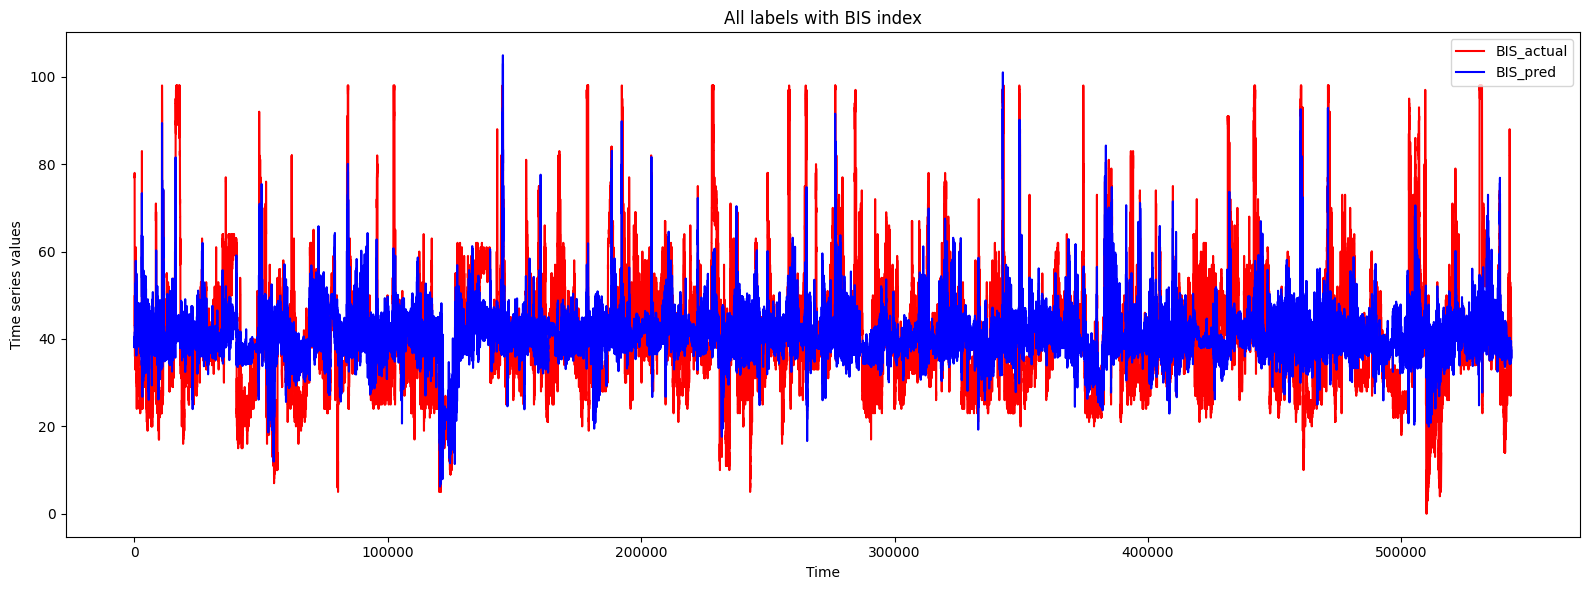

R2 score :  -0.1291123676788628
MAE for fold  {4}  =  10.659079
__________________
TEST


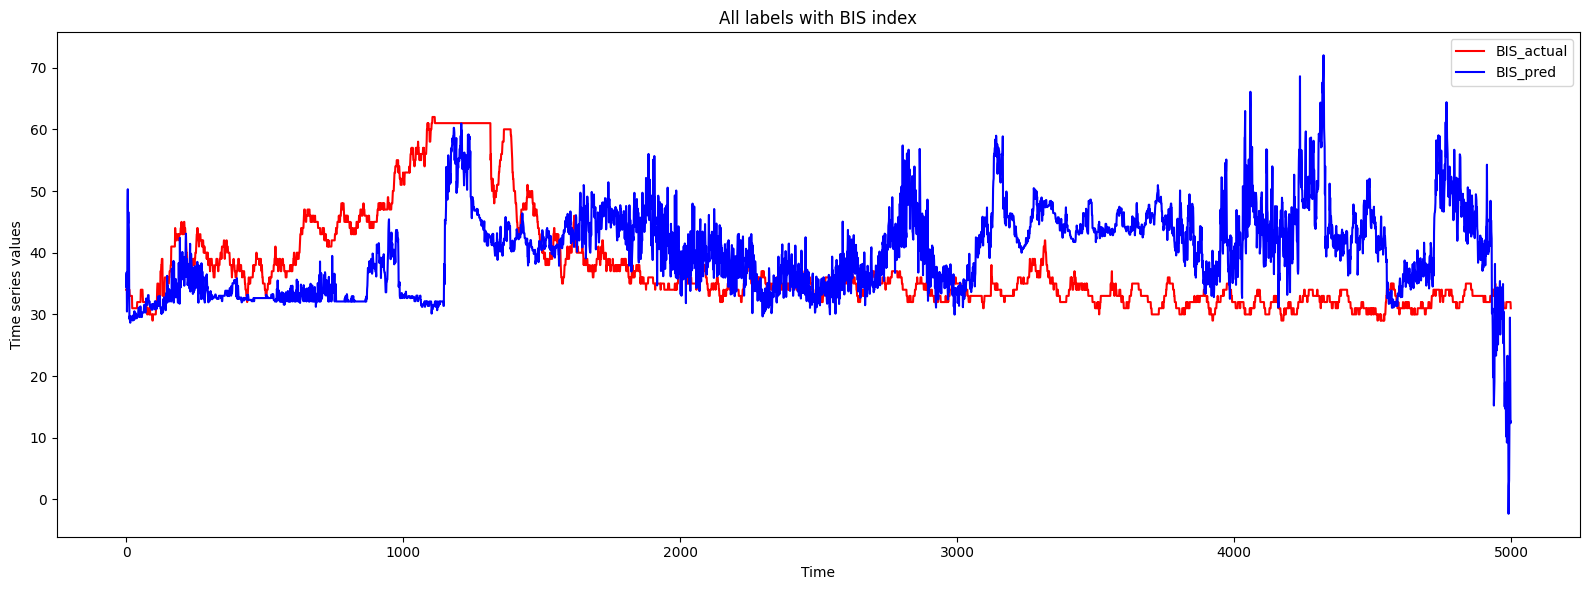

TOTAL


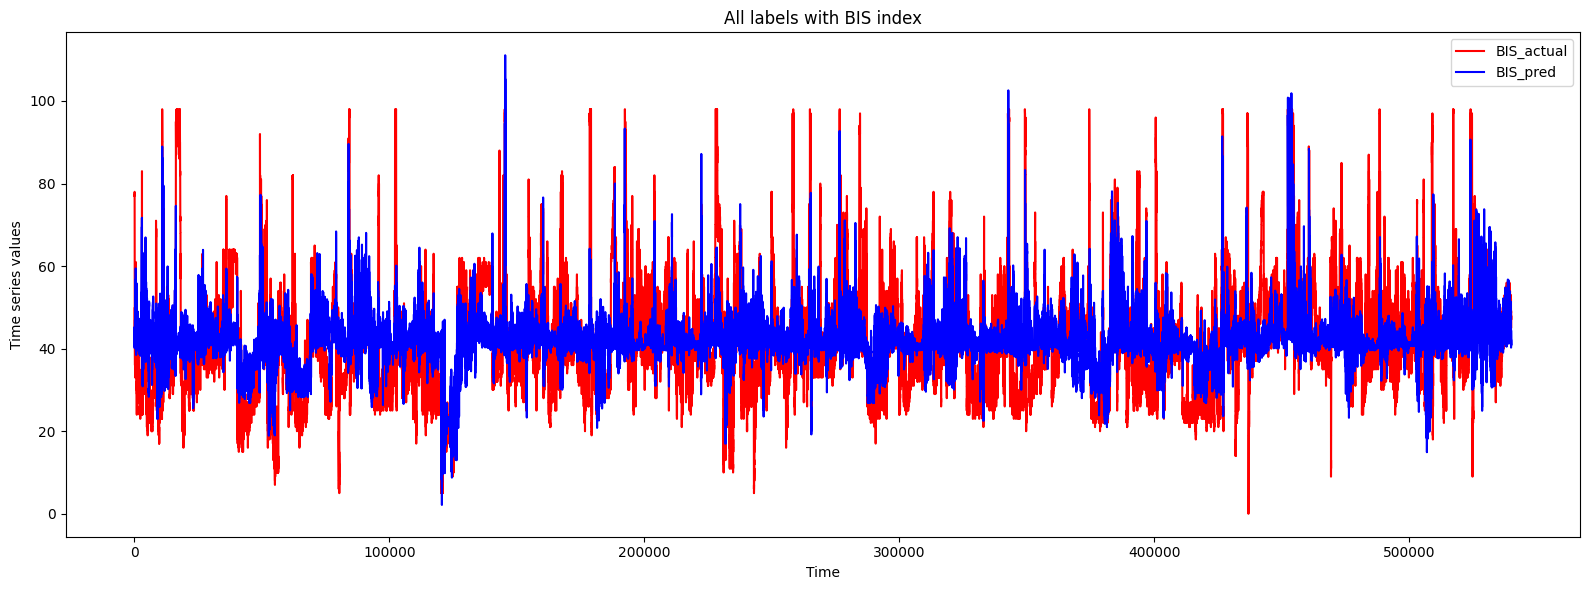

R2 score :  -0.10474858311822155
MAE for fold  {5}  =  11.497544
__________________
AVG MAE trained on fc  10.570831871032714


In [43]:
mae = 0
k = 5

i = 0
while i < k:
    testli = data[i]
    j = 0
    trainli = []
    while j < k:
        if (j == i):
            pass
        else:
            trainli = trainli + data[j]
        j = j+1
    
    testdf = pd.concat(testli, axis=0, ignore_index=True)
    traindf = pd.concat(trainli, axis=0, ignore_index=True)

    bis_t,pnim_t,fc_t,spo2_t,co2_t = generate_arrays(testdf)
    bis,pnim,fc,spo2,co2 = generate_arrays(traindf)

    mae_ = calcmse3(bis, fc, bis_t, fc_t, width=100, want_to_print = True, n_estim=100)
    mae = mae + mae_
    
    print("MAE for fold ", {i+1}, " = ",  mae_)
    print("__________________")

    i = i+1

print("AVG MAE trained on fc ", mae/k)



In [46]:
print("AVG MAE ", mse/k)


#Blockers:

# Extremely hard to visulaise full surgereis, tough to focus on parts where to see the performance on testing 
# MSE in terms of BIS value isnt really a great predictor of performance, so looked at MAE but it also gives a false idea sometimes so cheked r2 score 
# prediction value should be more sensitive to small fluctualtions in  most of the plane region, its observed to saturate to a constant value in those region. 


AVG MAE  11.379579162597656


In [47]:
# will be doing rweading this week, go through sequential model sgain and look for time-series specific attention based models.
# Work on classification task 
# SKORCH, look into building a piepeline to test pre-made models quuickly